# Prepare

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Install

In [2]:
!pip install rdkit
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ray[tune]
!pip install discordwebhook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 25.9 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.2 MB/s eta 0:00:00


## Import

In [3]:
!git clone https://github.com/Sawahiko/SMILE_to_Feature

Cloning into 'SMILE_to_Feature'...
remote: Enumerating objects: 2099, done.
remote: Counting objects: 100% (724/724), done.
remote: Compressing objects: 100% (582/582), done.
remote: Total 2099 (delta 137), reused 719 (delta 132), pack-reused 1375
Receiving objects: 100% (2099/2099), 195.18 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (840/840), done.
Updating files: 100% (812/812), done.


In [1]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import random

# Machine Learning
## Algorithm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
## Tool, Error Metric
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from joblib import dump, load

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader
#import pytorch_lightning as L

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

#Deep Learning Add
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

## ML Algorithm

In [2]:
from sklearn.linear_model import LinearRegression
def Linear_default(x_train, y_train):
  lm = LinearRegression()
  lm.fit(x_train, y_train)
  return lm

from sklearn.linear_model import Ridge
def Ridge_default(x_train, y_train):
  ridge = Ridge()
  ridge.fit(x_train, y_train)
  return ridge

from sklearn.linear_model import Lasso
def Lasso_default(x_train, y_train):
  lasso = Lasso()
  lasso.fit(x_train, y_train)
  return lasso

from sklearn.tree import DecisionTreeRegressor
def DT_default(x_train, y_train):
  DT = DecisionTreeRegressor()
  DT.fit(x_train, y_train)
  return DT

from sklearn.ensemble import RandomForestRegressor
def RF_default(x_train, y_train):
  RF = RandomForestRegressor()
  RF.fit(x_train, y_train)
  return RF

def XGB_default(x_train, y_train):
  XGB = XGBRegressor()
  XGB.fit(x_train, y_train)
  return XGB

from sklearn.neighbors import KNeighborsRegressor
def KNN_default(x_train, y_train):
  KNN = KNeighborsRegressor()
  KNN.fit(x_train, y_train)
  return KNN

from sklearn.svm import SVR
def SVM_default(x_train, y_train):
  svr = SVR()
  svr.fit(x_train, y_train)
  return svr

## ML Algorithm for GridSearch

In [3]:
from sklearn.model_selection import GridSearchCV
def RF(x_train, y_train):
    # Parameter grid for Optimized Parameter
    # Default : n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=1.0
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': [None, 1, 'sqrt', 'log2'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model


def XGB(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : max_depth=None/6 , learning_rate=None/0.3   , n_estimators=None
    param_grid = {
        'max_depth': [None, 3, 4, 5, 6, 7],
        'learning_rate': [None, 0.01, 0.05, 0.1, 0.2, 0.3],
        'n_estimators': [None, 100, 200, 300, 400]
    }

    xgb = XGBRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=kfold, scoring="neg_root_mean_squared_error")
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    #print(grid_search.cv_results_)
    print(grid_search.best_params_)
    return best_model

def DT(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : max_depth=None, min_samples_split=2,  min_samples_leaf=1
    param_grid = {
      'max_depth': [None, 3, 5, 7, 10],
      'min_samples_split': [2, 5, 10, 20],
      'min_samples_leaf': [1, 2, 5, 10]
    }

    dt = DecisionTreeRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(dt, param_grid=param_grid, cv=kfold)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    #print(grid_search.cv_results_)
    print(grid_search.best_params_)
    return best_model

def KNN(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : n_neighbors=5, weights='uniform',  algorithm='auto'
    param_grid = {
      'n_neighbors': [5, 10, 20, 50],
      'weights': ['uniform', 'distance'],
      'algorithm': ['auto','ball_tree', 'kd_tree', 'brute']
    }

    knn = KNeighborsRegressor()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(knn, param_grid=param_grid, cv=kfold)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    #print(grid_search.cv_results_)
    print(grid_search.best_params_)
    return best_model

def SVM_M(x_train, y_train):
    # Dictionary for GridSearchCV
    # Default Parameter : C=1, kernel='rbf',  degree=3, gamma='scale'
    param_grid = {
      'C': [0.1, 1, 10],
      'kernel': ['linear', 'rbf', 'poly'],
      'degree': [2, 3, 4],
      'gamma': ['scale', 0.01, 0.1, 0.3]
    }

    svr = SVR()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(svr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

## ML Algorithm for Select Best parameter

In [4]:
from sklearn.model_selection import GridSearchCV
#DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2)
#RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
#XGBRegressor(learning_rate=0.05, max_depth=3, n_estimators=200)
#KNeighborsRegressor(algorithm='brute', n_neighbors=50, weights='distance')

def RF_add(x_train, y_train):
    # Parameter grid for Optimized Parameter
    rf = RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust number of splits as needed

    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model


def XGB_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 400]
    }

    xgb = XGBRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def DT_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
      'max_depth': [3, 5, 7, 10],
      'min_samples_split': [2, 5, 10, 20],
      'min_samples_leaf': [1, 2, 5, 10]
    }

    dt = DecisionTreeRegressor(random_state=42)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(dt, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

def KNN_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
      'n_neighbors': [5, 10, 20, 50],
      'weights': ['uniform', 'distance'],
      'algorithm': ['ball_tree', 'kd_tree', 'brute']
    }

    knn = KNeighborsRegressor()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(knn, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model
def SVM_M_add(x_train, y_train):
    # Dictionary for GridSearchCV
    param_grid = {
      'C': [0.1, 1, 10],
      'kernel': ['linear', 'rbf', 'poly'],
      'degree': [2, 3, 4],
      'gamma': [0.01, 0.1, 0.3]
    }

    svr = SVR()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(svr, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    return best_model

# Run Training

## Before

In [3]:
#%% Import Data
df = pd.read_csv(r"C:\Users\Kan\Documents\GitHub\SMILE_to_Feature\Second Semester\[Use] Main File/Psat_NO_ABCTminTmaxC1-12.csv")
df = df[df['SMILES'] != "None"]
df = df.drop_duplicates(subset='SMILES').reset_index(drop=True)
df.sort_values(by="No.C")
#len(df["SMILES"].unique())

,Unnamed: 0,Column1,Name,SMILES,A,B,C,Tmin,Tmax,No.C,Atom,Count Unique Atom,Pass Screen,Atom2
0,0,0,Methanal,C=O,21.370292,2204.126554,-30.150,190,271,1,"[1, 6, 8]",3,True,CHO
33,58,75,Formamide,C(=O)N,23.311763,5274.025104,-44.106,391,466,1,"[1, 6, 7, 8]",4,True,CHON
1226,2239,2630,Methyl hydroperoxide,COO,24.159183,4521.153461,-0.696,243,323,1,"[1, 6, 8]",3,True,CHO
760,1340,1560,Methyl nitrate,CO[N+](=O)[O-],22.885554,3653.755841,-15.925,263,333,1,"[1, 6, 7, 8]",4,True,CHON
504,768,888,Carbon dioxide,C(=O)=O,21.787336,1722.978373,-16.900,216,273,1,"[6, 8]",2,True,CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,853,997,Biphenylene,C1=CC=C2C(=C1)C3=CC=CC=C23,22.477513,5342.621416,-51.020,338,408,12,"[1, 6]",2,True,CH
202,344,411,Tributylamine,CCCCN(CCCC)CCCC,20.560312,3547.811598,-93.996,336,488,12,"[1, 6, 7]",3,True,CHN
1966,3546,4298,"3-Ethyl-2,6-dimethyloctane",CCC(C)CCC(CC)C(C)C,20.142945,3291.637494,-88.150,470,470,12,"[1, 6]",2,True,CH
1997,3577,4329,"3,4-Diethyl-2,4-dimethylhexane",CCC(C(C)C)C(C)(CC)CC,19.919272,3214.592997,-90.150,473,473,12,"[1, 6]",2,True,CH


## Split

In [52]:
# New Train-Test Split
random.seed(42)
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [53]:
# Genearate Temp in Tmin-Tmax and expand
df1 = train.copy()
    ## Function to generate equally distributed points
def generate_points(row, amount_point):
    start = row["Tmin"]; end = row["Tmax"];
    return np.linspace(start, end, amount_point)
df1["T"] = df1.apply(lambda x : generate_points(x, 5), axis=1)

df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
df1 = df1.reset_index(drop=True)

# Generate VP from Antione Coeff and Temp
def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))

df1["Vapor_Presssure"] = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])
#test = df1[df1["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])]
#print(test[['SMILES','Vapor_Presssure']].sort_values(by="Vapor_Presssure").head(5))
#print(f"\n {test[['SMILES','Vapor_Presssure']].index} ")
# Get Needed Table and split for Training
df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
df2 = df2[~df2["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])].reset_index()
#print(df2[['SMILES','Vapor_Presssure']].sort_values(by="Vapor_Presssure").head(5))
X_data= df2[["SMILES"]]               # feature: SMILE, T
Y_data= df2[["Vapor_Presssure"]]        # Target : Psat
print(df2.sort_values(by="Vapor_Presssure"))
df2_train = df2.copy()

      index                          SMILES      T  Vapor_Presssure
4125   4125                  C(CO)N(CCO)N=O  273.0        -5.527856
3880   3880                     CC(C)(C)N=O  288.0        -5.178898
3881   3881                     CC(C)(C)N=O  293.0        -4.636487
3485   3485  C(CO[N+](=O)[O-])O[N+](=O)[O-]  240.0        -4.204737
3882   3882                     CC(C)(C)N=O  298.0        -4.112278
...     ...                             ...    ...              ...
4030   4030                      C1CCC(C1)N  318.0        18.435562
4031   4031                      C1CCC(C1)N  343.0        18.646947
4032   4032                      C1CCC(C1)N  368.0        18.822911
4033   4033                      C1CCC(C1)N  393.0        18.971667
4034   4034                      C1CCC(C1)N  418.0        19.099075

[8340 rows x 4 columns]


In [54]:
# %% Fingerprint
# Parameter for Generate Morgan Fingerprint
MF_radius = 3;   MF_bit = 2048

# Generate Fingerprint from SMILE
X_data_use = X_data.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))    # Create Mol object from SMILES
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))         # Create Morgan Fingerprint from Mol object


# Transfrom Fingerprint to Datafrme that we can use for training
X_data_use["arr_count_morgan_fp"] = 0
X_data_fp = []
for i in range(X_data_use.shape[0]):
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)

# Final Data for Training
x_data_fp[MF_bit] = df2["T"]      # Input  = Fingerprint + Temp
y_data_fp = Y_data.copy()         # Output = Vapor Pressure

x_train_notz = x_data_fp.copy()
y_train_notz = np.ravel(y_data_fp.copy())

In [55]:
# Genearate Temp in Tmin-Tmax and expand
df1 = test.copy()
    ## Function to generate equally distributed points
def generate_points(row, amount_point):
    start = row["Tmin"]; end = row["Tmax"];
    return np.linspace(start, end, amount_point)
df1["T"] = df1.apply(lambda x : generate_points(x, 5), axis=1)

df1  = df1.explode('T')
df1['T'] = df1['T'].astype('float32')
df1 = df1.reset_index(drop=True)
#print(test)
# Generate VP from Antione Coeff and Temp
def Psat_cal(T,A,B,C):
    #return pow(A-(B/(T+C)),10)/(10^(3))
    return A-(B/(T+C))

df1["Vapor_Presssure"] = Psat_cal(df1["T"], df1["A"], df1["B"], df1["C"])

# Get Needed Table and split for Training
df2 = df1[["SMILES", "T", "Vapor_Presssure"]]
df2 = df2[~df2["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])].reset_index()
X_data= df2[["SMILES"]]               # feature: SMILE, T
Y_data= df2[["Vapor_Presssure"]]        # Target : Psat
#df[df["SMILES"].isin(df2[df2["Vapor_Presssure"] <-20]["SMILES"])]
print(df2.sort_values(by="Vapor_Presssure"))
df2_test = df2.copy()

      index                                             SMILES      T  \
1865   1865                                    CCCCCCC1COCCC1O  293.0   
1866   1866                                    CCCCCCC1COCCC1O  313.0   
1740   1740                                   CCCC(C#N)N(CC)CC  283.0   
135     135                             COC1=C(C=CC(=C1)CC=C)O  288.0   
360     360  CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=...  353.0   
...     ...                                                ...    ...   
266     266                                      CC(=O)OC(=O)C  485.0   
869     869                                        CC(CO)C(C)O  561.0   
267     267                                      CC(=O)OC(=O)C  505.0   
268     268                                      CC(=O)OC(=O)C  525.0   
269     269                                      CC(=O)OC(=O)C  545.0   

      Vapor_Presssure  
1865        -2.641542  
1866        -0.692817  
1740        -0.378905  
135         -0.326221  
360

In [56]:
# %% Fingerprint
# Parameter for Generate Morgan Fingerprint
MF_radius = 3;   MF_bit = 2048

# Generate Fingerprint from SMILE
X_data_use = X_data.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))    # Create Mol object from SMILES
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x,
    radius=MF_radius,
    nBits=MF_bit,
    useFeatures=True, useChirality=True))         # Create Morgan Fingerprint from Mol object


# Transfrom Fingerprint to Datafrme that we can use for training
X_data_use["arr_count_morgan_fp"] = 0
X_data_fp = []
for i in range(X_data_use.shape[0]):
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)
x_data_fp = pd.concat(X_data_fp, ignore_index=True)
x_data_fp = x_data_fp.astype(np.float32)

# Final Data for Training
x_data_fp[MF_bit] = df2["T"]      # Input  = Fingerprint + Temp
y_data_fp = Y_data.copy()         # Output = Vapor Pressure

x_test_notz = x_data_fp.copy()
y_test_notz = np.ravel(y_data_fp.copy())

## Split and Normalization

In [57]:
#%% Train-test split Data
#x_train_fp, x_test_fp, y_train_fp, y_test_fp = train_test_split(x_data_fp, np.ravel(y_data_fp),test_size=0.2,random_state=42)
#x_train_notz, x_test_notz, y_train_notz, y_test_notz = train_test_split(x_data_fp, np.ravel(y_data_fp),test_size=0.2,random_state=42)

In [58]:
x_train_notz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8340 entries, 0 to 8339
Columns: 2049 entries, 0 to 2048
dtypes: float32(2049)
memory usage: 65.2 MB


In [59]:
x_test_notz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Columns: 2049 entries, 0 to 2048
dtypes: float32(2049)
memory usage: 17.3 MB


In [60]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale_x= StandardScaler()
scale_x.fit(x_train_notz)
print(scale_x)
scale_y= StandardScaler()
scale_y.fit(y_train_notz.reshape(-1,1))
print(scale_y)
x_train_fp = scale_x.transform(x_train_notz)
x_test_fp  = scale_x.transform(x_test_notz)

y_train_fp = scale_y.transform(y_train_notz.reshape(-1,1)).flatten()
y_test_fp  = scale_y.transform(y_test_notz.reshape(-1,1)).flatten()

StandardScaler()
StandardScaler()


In [61]:
x_train_fp

array([[-1.7871615 , -0.18278635,  0.2497429 , ..., -0.02449245,
        -0.03464795, -2.8952346 ],
       [-1.7871615 , -0.18278635,  0.2497429 , ..., -0.02449245,
        -0.03464795, -2.6048365 ],
       [-1.7871615 , -0.18278635,  0.2497429 , ..., -0.02449245,
        -0.03464795, -2.314438  ],
       ...,
       [-0.5801627 , -0.18278635,  0.2497429 , ..., -0.02449245,
        -0.03464795, -0.5505376 ],
       [-0.5801627 , -0.18278635,  0.2497429 , ..., -0.02449245,
        -0.03464795, -0.40354586],
       [-0.5801627 , -0.18278635,  0.2497429 , ..., -0.02449245,
        -0.03464795, -0.25655416]], dtype=float32)

In [62]:
x_test_fp

array([[-1.183662  ,  4.815372  ,  1.0930042 , ..., -0.02449245,
        -0.03464795, -0.77281773],
       [-1.183662  ,  4.815372  ,  1.0930042 , ..., -0.02449245,
        -0.03464795, -0.34618324],
       [-1.183662  ,  4.815372  ,  1.0930042 , ..., -0.02449245,
        -0.03464795,  0.08045125],
       ...,
       [ 0.02333676, -0.18278635,  2.779527  , ..., -0.02449245,
        -0.03464795, -0.59355956],
       [ 0.02333676, -0.18278635,  2.779527  , ..., -0.02449245,
        -0.03464795, -0.35335356],
       [ 0.02333676, -0.18278635,  2.779527  , ..., -0.02449245,
        -0.03464795, -0.11314759]], dtype=float32)

In [63]:
y_train_fp

array([-0.86811926, -0.21464666,  0.3067289 , ..., -2.1809978 ,
       -1.89098626, -1.6300178 ])

In [64]:
y_test_fp

array([-1.35431835, -0.66708873, -0.09750156, ..., -1.87903629,
       -1.43012849, -1.03239786])

## Training Function

In [65]:
#%% Training Model
from datetime import datetime

def model_assess(X_train, X_test, y_train, y_test, list_model, name_model, all_time_fitting, title = "Default"):
  model_assess_table = pd.DataFrame(['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']).transpose()
  new_header = model_assess_table.iloc[0] #grab the first row for the header
  model_assess_table.columns = new_header #set the header row as the df header
  model_assess_table.drop(index=model_assess_table.index[0], axis=0, inplace=True)

  train_prediction_table = pd.DataFrame(['Method','Training Predict','Training Actual']).transpose()
  new_header = train_prediction_table.iloc[0] #grab the first row for the header
  train_prediction_table.columns = new_header #set the header row as the df header
  train_prediction_table.drop(index=train_prediction_table.index[0], axis=0, inplace=True)

  test_prediction_table = pd.DataFrame(['Method','Test Predict','Test Actual']).transpose()
  new_header = test_prediction_table.iloc[0] #grab the first row for the header
  test_prediction_table.columns = new_header #set the header row as the df header
  test_prediction_table.drop(index=test_prediction_table.index[0], axis=0, inplace=True)


  for iteration in range(len(list_model)):
      time_start = datetime.now()
      model_train = list_model[iteration]
      name = name_model[iteration]

      if("DL" not in name):
        model_train.fit(X_train, y_train)
        y_train_pred = model_train.predict(X_train)
        y_test_pred  = model_train.predict(X_test)
      else:
        pass

      time_end = datetime.now()
      duration = (time_end - time_start).total_seconds()
      print(name)
      print(duration)

      train_mae = mean_absolute_error(y_train, y_train_pred)
      train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
      train_r2 = r2_score(y_train, y_train_pred)
      test_mae = mean_absolute_error(y_test, y_test_pred)
      test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
      test_r2 = r2_score(y_test, y_test_pred)

      results = pd.DataFrame([name_model[iteration],train_mae, train_rmse, train_r2, test_mae, test_rmse, test_r2, duration]).transpose()
      results.columns = ['Method','Training MAE', 'Training RMSE','Training R2','Test MAE', 'Test RMSE','Test R2', 'Time Evaluate']


      train_prediction_result = pd.DataFrame([name_model[iteration],y_train_pred, y_train]).transpose()
      train_prediction_result.columns = ['Method','Training Predict','Training Actual']

      test_prediction_result = pd.DataFrame([name_model[iteration], y_test_pred, y_test]).transpose()
      test_prediction_result.columns = ['Method','Test Predict','Test Actual']

      model_assess_table = pd.concat([model_assess_table, results])
      train_prediction_table = pd.concat([train_prediction_table, train_prediction_result])
      test_prediction_table = pd.concat([test_prediction_table, test_prediction_result])
  model_assess_table['Time Training'] = all_time_fitting
  return model_assess_table, train_prediction_table, test_prediction_table

# Inspect All ML Algorithm

## Training Setup & Run

In [ ]:
# Specified model need to run
#names = ["XGB", "RF", "DL1", "DL2"]
#models = [XGB, RF, DL, DL2 ]

names = ["MLR", "Ridge", "Lasso", "DT", "RF", "XGB", "KNN", "SVM"]
models = [Linear_default, Ridge_default, Lasso_default, DT_default, RF_default, XGB_default, KNN_default, SVM_default]

# Run Training Model
all_result_model = []
all_time_fitting = []
for iteration in range(len(names)) :
    get_model = models[iteration]
    time_start = datetime.now()
    result_model = get_model(x_train_fp, y_train_fp)
    time_end = datetime.now()
    duration = (time_end - time_start).total_seconds()
    print(result_model)
    print(f'{duration} seconds')
    all_result_model.append(result_model)
    all_time_fitting.append(duration)

LinearRegression()
16.275789 seconds
Ridge()
2.148519 seconds
Lasso()
0.245683 seconds
DecisionTreeRegressor()
1.641599 seconds
RandomForestRegressor()
111.757276 seconds
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
9.253873 seconds
KNeighborsRegressor()
0.102441 seconds
SVR()
342.924149 seconds


In [ ]:
all_time_fitting

[16.275789,
 2.148519,
 0.245683,
 1.641599,
 111.757276,
 9.253873,
 0.102441,
 342.924149]

## Model Evaluation

In [ ]:
# %% Model Evaluation
# Evaluate Model
result_evaluation, train_prediction_original, test_prediction_original = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, all_result_model, names, all_time_fitting)

In [ ]:
result_evaluation

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate,Time Training
0,MLR,0.120242,0.205048,0.957955,17575.861013,36564.333744,-1404982269.224429,8.666176,16.275789
0,Ridge,0.109644,0.19858,0.960566,0.902916,1.534602,-1.474839,1.584378,2.148519
0,Lasso,0.764187,1.0,-0.0,0.764329,0.975745,-0.000526,0.277509,0.245683
0,DT,0.0,0.0,1.0,0.25912,0.509818,0.72686,1.61991,1.641599
0,RF,0.040515,0.073131,0.994652,0.203711,0.417229,0.817062,110.724883,111.757276
0,XGB,0.100313,0.144011,0.979261,0.210217,0.392498,0.838106,9.697002,9.253873
0,KNN,0.118201,0.220635,0.95132,0.569565,0.852205,0.236791,81.656229,0.102441
0,SVM,0.251537,0.421574,0.822275,0.426958,0.631323,0.58115,880.326835,342.924149


In [ ]:
train_prediction_original

,Method,Training Predict,Training Actual
0,MLR,"[-0.4341798, -0.28313234, -0.13208513, 0.01896...","[-0.9175107264767643, -0.5913485194419537, -0...."
0,Ridge,"[-0.4409559, -0.2897046, -0.13845326, 0.012797...","[-0.9175107264767643, -0.5913485194419537, -0...."
0,Lasso,"[3.613686e-09, 3.613686e-09, 3.613686e-09, 3.6...","[-0.9175107264767643, -0.5913485194419537, -0...."
0,DT,"[-0.9175107264767643, -0.5913485194419537, -0....","[-0.9175107264767643, -0.5913485194419537, -0...."
0,RF,"[-0.7507723402895968, -0.570642272997719, -0.2...","[-0.9175107264767643, -0.5913485194419537, -0...."
0,XGB,"[-0.5470968, -0.5470968, -0.5470968, 0.1115182...","[-0.9175107264767643, -0.5913485194419537, -0...."
0,KNN,"[-0.3266126487852854, -0.3266126487852854, -0....","[-0.9175107264767643, -0.5913485194419537, -0...."
0,SVM,"[-0.6520733088269254, -0.4927636270051521, -0....","[-0.9175107264767643, -0.5913485194419537, -0...."


In [ ]:
test_prediction_original

,Method,Test Predict,Test Actual
0,MLR,"[-61196.145, -61195.797, -61195.445, -61195.09...","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,Ridge,"[-4.280796, -3.931611, -3.5824263, -3.233241, ...","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,Lasso,"[3.613686e-09, 3.613686e-09, 3.613686e-09, 3.6...","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,DT,"[-2.14343863290499, -1.6200773425526134, -1.07...","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,RF,"[-1.7192234005637963, -1.2298526215658332, -0....","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,XGB,"[-2.3418543, -1.3567997, -0.9031658, -0.166621...","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,KNN,"[0.19030122452311038, 0.19030122452311038, 0.1...","[-2.1303843289912563, -1.625523666710458, -1.1..."
0,SVM,"[-0.5146501449835675, -0.5094630637989332, -0....","[-2.1303843289912563, -1.625523666710458, -1.1..."


In [ ]:
result_evaluation = result_evaluation.reset_index(drop=True)
train_prediction = train_prediction_original.reset_index(drop=True).explode(['Training Predict', 'Training Actual'])
test_prediction = test_prediction_original.reset_index(drop=True).explode(['Test Predict', 'Test Actual'])


# Change datatype
def change_data_type(x):
  try :
    #print(x[0])
    try:
      #print(x[0][0])
      return float(x[0][0])
    except:
      return float(x[0])
  except:
    return float(x)

def change_data_type2(x):
  return float(x[0])

test_prediction['Test Predict'] = test_prediction['Test Predict'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))
train_prediction['Training Predict'] = train_prediction['Training Predict'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))
test_prediction['Test Actual'] = test_prediction['Test Actual'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))
train_prediction['Training Actual'] = train_prediction['Training Actual'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))

test_prediction['Test Predict'] = test_prediction['Test Predict'].apply(lambda x: change_data_type(x))
test_prediction['Test Actual'] = test_prediction['Test Actual'].apply(lambda x: change_data_type(x))
train_prediction['Training Predict'] = train_prediction['Training Predict'].apply(lambda x: change_data_type(x))
train_prediction['Training Actual'] = train_prediction['Training Actual'].apply(lambda x: change_data_type(x))

In [ ]:
result2 = result_evaluation.head(0).copy()
result2

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate,Time Training


In [ ]:
result_test = test_prediction.groupby("Method").agg(lambda x: list(x)).reset_index()
result_train = train_prediction.groupby("Method").agg(lambda x: list(x)).reset_index()
print(result_train)
print(result_test)

  Method                                   Training Predict  \
0     DT  [7.5815743599474885, 8.316537113830654, 8.9771...   
1    KNN  [8.913083863738795, 8.913083863738795, 8.91308...   
2  Lasso  [9.64906120300293, 9.64906120300293, 9.6490612...   
3    MLR  [8.670695304870605, 9.01106071472168, 9.351425...   
4     RF  [7.9572969324804745, 8.363195860862048, 9.0607...   
5  Ridge  [8.655426979064941, 8.996251106262207, 9.33707...   
6    SVM  [8.179701951838416, 8.5386849362143, 8.8979734...   
7    XGB  [8.416252136230469, 8.416252136230469, 8.41625...   

                                     Training Actual  
0  [7.5815743599474885, 8.316537113830654, 8.9771...  
1  [7.5815743599474885, 8.316537113830654, 8.9771...  
2  [7.5815743599474885, 8.316537113830654, 8.9771...  
3  [7.5815743599474885, 8.316537113830654, 8.9771...  
4  [7.5815743599474885, 8.316537113830654, 8.9771...  
5  [7.5815743599474885, 8.316537113830654, 8.9771...  
6  [7.5815743599474885, 8.316537113830654, 8.97

In [ ]:
func_name = ["MAE", "RMSE", "R2"]
rmse_func = lambda x,y : mean_squared_error(x,y, squared=False)
func_list = [mean_absolute_error, rmse_func, r2_score]
def create_result_from_predict_value(table_predict, func_name, func_list):
    list_df = list()
    name_method = pd.Series(table_predict.apply(lambda x : x[0], axis=1), name="Method")
    df_1 = name_method.to_frame();   list_df.append(df_1)
    for i in range(len(func_list)):
      list_error_metric = []

      name_fx = func_name[i]
      func    = func_list[i]
      #name_method = pd.Series(table_predict.apply(lambda x : x[0], axis=1), name="Method")
      value = pd.Series(table_predict.apply(lambda x : func(x[1], x[2]), axis=1),name=name_fx)
      df_2=value.to_frame()
      #print(df_1)
      #print(df_2)
      #df_combine = pd.merge(df_1, df_2, how='inner', left_index=True, right_index=True)
      #df_combine = pd.concat([df_1, df_2], axis=1)
      list_df.append(df_2)

    return pd.concat(list_df, axis=1)



print(create_result_from_predict_value(result_train, func_name, func_list))
print("\n")
#print(create_result_from_predict_value(result_test.drop([2,3,5,6],axis=0), func_name, func_list).reset_index(drop=True))
print(create_result_from_predict_value(result_test, func_name, func_list).reset_index(drop=True))

  Method           MAE          RMSE        R2
0     DT  9.148222e-11  1.879843e-09  1.000000
1    KNN  2.663505e-01  4.971715e-01  0.940497
2  Lasso  1.721994e+00  2.253366e+00  0.000000
3    MLR  2.709493e-01  4.620473e-01  0.956410
4     RF  9.129435e-02  1.647899e-01  0.994392
5  Ridge  2.470677e-01  4.474733e-01  0.958899
6    SVM  5.668044e-01  9.499612e-01  0.725391
7    XGB  2.260425e-01  3.245088e-01  0.978089


  Method           MAE          RMSE        R2
0     DT      0.583892      1.148806  0.690174
1    KNN      1.283439      1.920329 -0.221905
2  Lasso      1.722314      2.198711  0.000000
3    MLR  39604.843685  82392.818202 -0.000252
4     RF      0.459036      0.940169  0.755164
5  Ridge      2.034599      3.458019  0.334445
6    SVM      0.962093      1.422602  0.058091
7    XGB      0.473695      0.884441  0.798002


## Visualization

In [ ]:
#test_prediction_visual = test_prediction[test_prediction["Method"].isin(["DT", "RF", "XGB", "KNN"])]
test_prediction_visual = test_prediction[test_prediction["Method"].isin(["MLR", "SVM", "Lasso", "Ridge","DT", "RF", "XGB", "KNN"])]
test_prediction_visual[test_prediction_visual["Test Actual"]<-20]
print(f'min = {min(test_prediction_visual["Test Actual"])}  max = {max(test_prediction_visual["Test Actual"])}')

min = -3.2083565368507365  max = 14.324343315957439


(-469738.28125, 382848.0625)

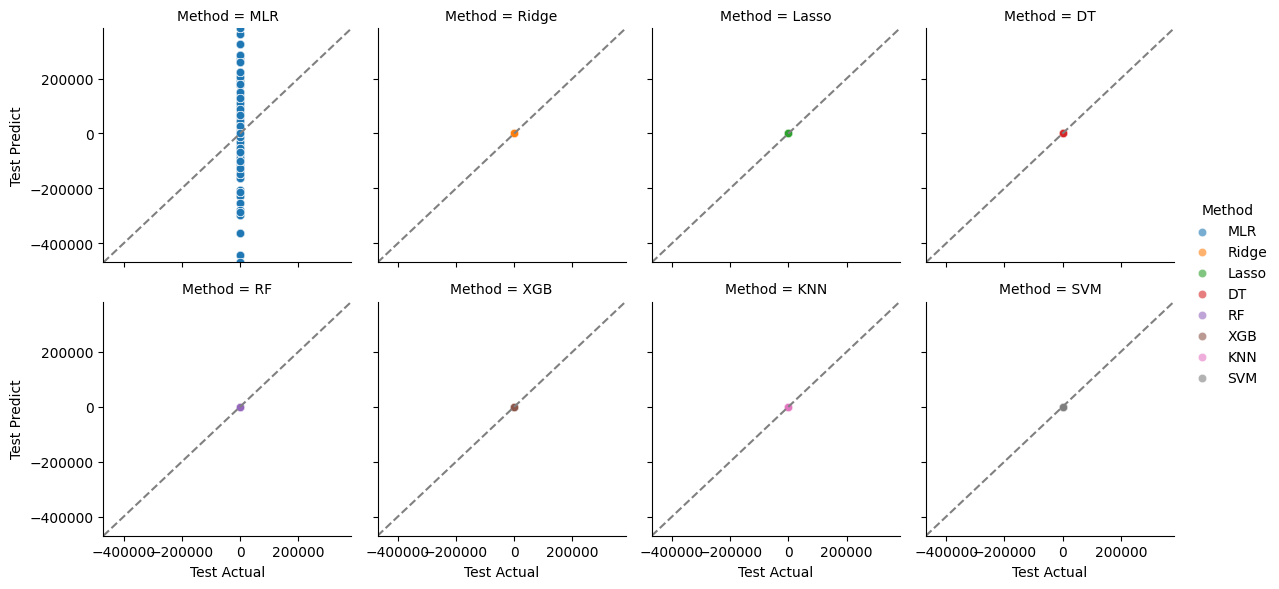

In [ ]:
#%% Visualization
# Specified Range for plot
x_min = min(min(test_prediction_visual["Test Predict"]),min(test_prediction_visual["Test Actual"]))-20
x_max = max(max(test_prediction_visual["Test Predict"]),max(test_prediction_visual["Test Actual"]))+20
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction_visual, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

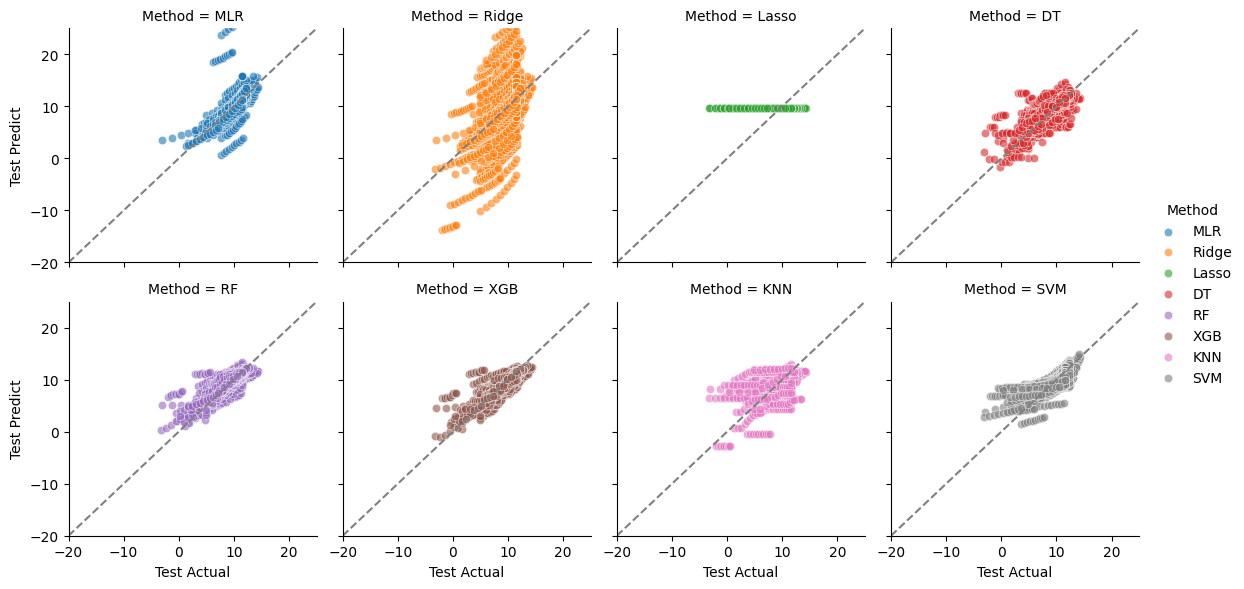

In [ ]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction_visual, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(0.0, 2.5)

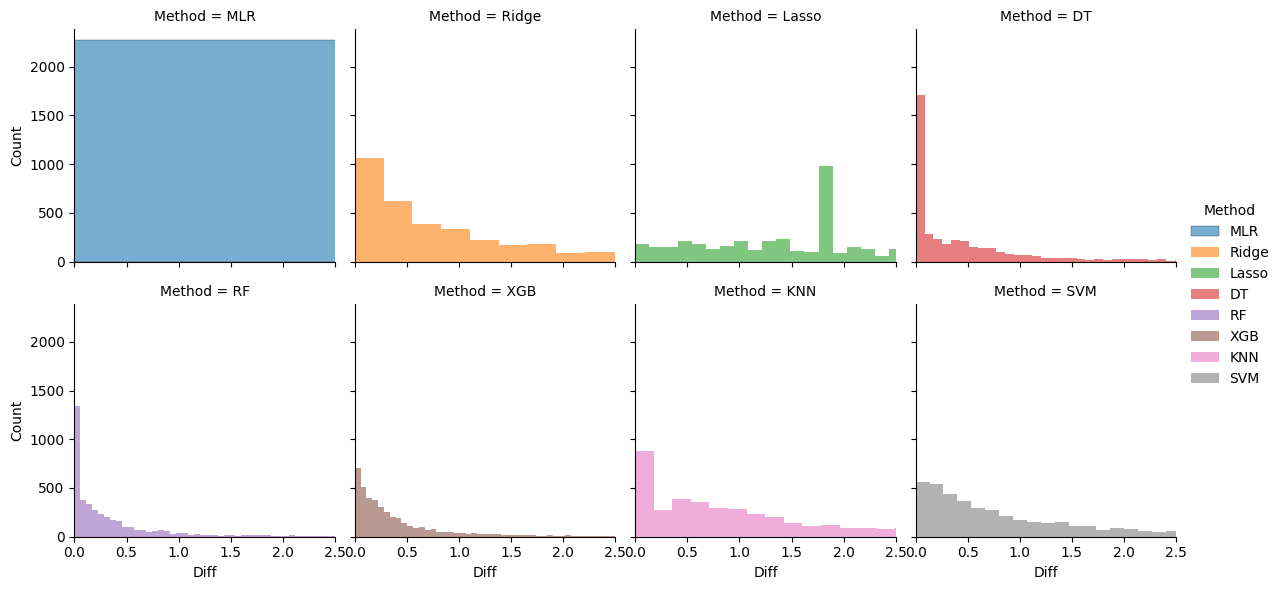

In [ ]:
test_prediction_visual["Diff"] = abs(test_prediction_visual["Test Actual"] - test_prediction_visual["Test Predict"])
#sns.histplot(data=test_prediction_visual, x="Diff")

g = sns.FacetGrid(test_prediction_visual, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.histplot, x="Diff", alpha=0.6)

g.add_legend()
plt.xlim(0, 2.5)
#plt.ylim(y_min, y_max)

(-10.0, 10.0)

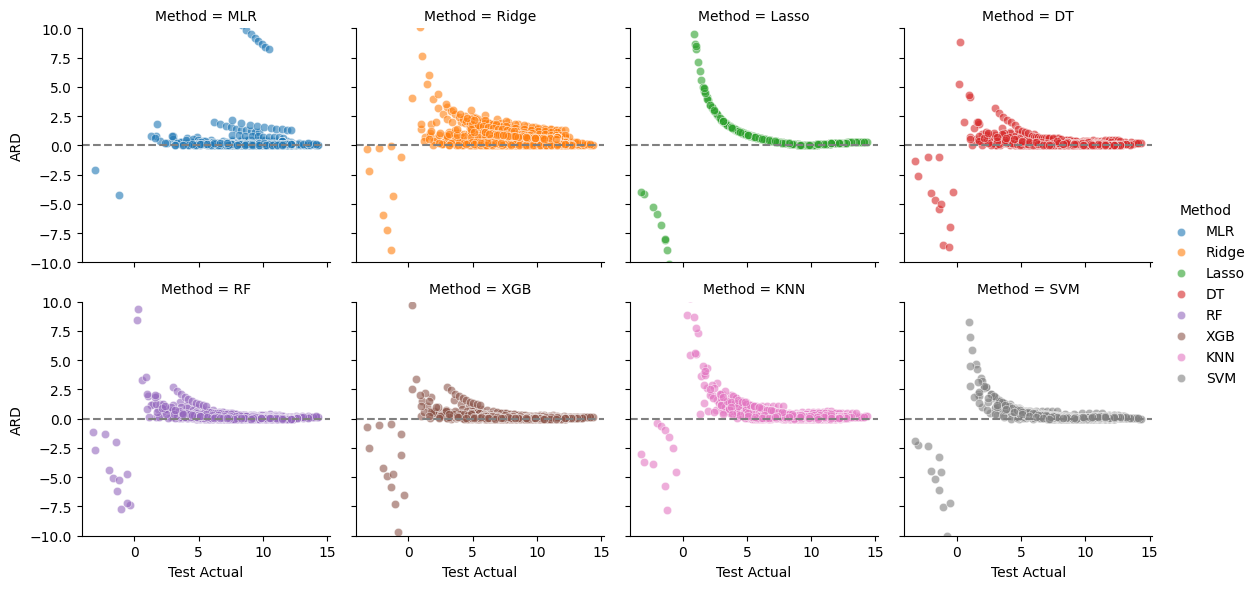

In [ ]:
test_prediction_visual["ARD"] = test_prediction_visual["Diff"] / test_prediction_visual["Test Actual"]

# Plot each method
g = sns.FacetGrid(test_prediction_visual, col="Method", col_wrap=4, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="ARD", alpha=0.6)
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=0, color='.5', linestyle='--'))

g.add_legend()
#plt.xlim(0, 2.5)
plt.ylim(-10, 10)

# Send Line ML-Default

In [ ]:
import requests
url = 'https://notify-api.line.me/api/notify'
token = '3CfMWfczpal9Zye6bD72a8Ud6FWOODnBHQZHIWM1YU4'
headers = {'content-type':'application/x-www-form-urlencoded','Authorization':'Bearer '+token}

msg = f'run ML Default เสร็จแล้ว'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)


from discordwebhook import Discord
discord_sky = Discord(url="https://discord.com/api/webhooks/1199614974293717103/TBi5ecy1kOZoE1bOfiHoeygsRFS1DTIp-2-f4RjSaqLbQwBki6g7M2baYJX88igNBre9")
discord_sky.post(content="run ML Default เสร็จแล้ว")

{"status":200,"message":"ok"}


<Response [204]>

# Inspect Best ML Algorithm

## Training Setup & Run

In [ ]:

# Specified model need to run
#names_bestpar = ["DT", "RF", "XGB", "KNN"]
names_bestpar = ["RF"]
#models_bestpar = [DT, RF, XGB, KNN]
models_bestpar = [RF]
#models_bestpar = [KNN, RF, XGB, KNN]

# Run Training Model
all_result_model_bestpar = []
all_time_fitting_bestpar = []
for iteration in range(len(names_bestpar)) :
    get_model = models_bestpar[iteration]
    time_start = datetime.now()
    result_model = get_model(x_train_fp, y_train_fp.flatten())
    time_end = datetime.now()
    duration = (time_end - time_start).total_seconds()
    print(result_model)
    print(f'{duration} seconds\n')
    all_result_model_bestpar.append(result_model)
    all_time_fitting_bestpar.append(duration)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [ ]:
all_time_fitting_bestpar

## Result GridSearchCV

In [23]:
'''
4 Point
----------------------------------------------------------------------
Default
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeRegressor(min_samples_split=10, random_state=42)
176.166672 seconds

30 job
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeRegressor(min_samples_split=10, random_state=42)
250.974434 seconds

-1 job
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeRegressor(min_samples_split=10, random_state=42)
197.055876 seconds


{'learning_rate': None, 'max_depth': 5, 'n_estimators': 400}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
5084.590967 seconds
----------------------------------------------------------------------
10 point
----------------------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeRegressor(random_state=42)
848.863742 seconds

{'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 400}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
10740.096611 seconds

{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(max_features=None, n_estimators=200, random_state=42)
99537.743466 seconds

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsRegressor(weights='distance')
8496.117516 seconds
------------------------------------------------------
5 point
------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeRegressor(random_state=42)
617.038372 seconds

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 400}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
12165.219083 seconds

{'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsRegressor(algorithm='kd_tree', weights='distance')
9896.092124 seconds

{'max_depth': None, 'max_features': None, 'n_estimators': 200}
RandomForestRegressor(max_features=None, n_estimators=200, random_state=42)
10299.279165 seconds
'''

"\n4 Point\n----------------------------------------------------------------------\nDefault\n{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}\nDecisionTreeRegressor(min_samples_split=10, random_state=42)\n176.166672 seconds\n\n30 job\n{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}\nDecisionTreeRegressor(min_samples_split=10, random_state=42)\n250.974434 seconds\n\n-1 job\n{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}\nDecisionTreeRegressor(min_samples_split=10, random_state=42)\n197.055876 seconds\n\n\n{'learning_rate': None, 'max_depth': 5, 'n_estimators': 400}\nXGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, device=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, grow_policy=None, importance_type=None,\n             interaction

In [66]:
# for Add
names_bestpar = ["DT", "RF", "XGB", "KNN"]
all_time_fitting_bestpar = [617.038372, 10299.279165, 12165.219083, 9896.092124]
all_result_model_bestpar =[
    DecisionTreeRegressor(random_state=42).fit(x_train_fp, y_train_fp),
    RandomForestRegressor(max_features=None, n_estimators=200, random_state=42).fit(x_train_fp, y_train_fp),
    XGBRegressor(learning_rate=0.2, max_depth=7, n_estimators=400, random_state=42).fit(x_train_fp, y_train_fp),
    KNeighborsRegressor(algorithm='kd_tree', n_neighbors=5, weights='distance').fit(x_train_fp, y_train_fp),
]

## Model Evaluation

In [67]:
# %% Model Evaluation
# Evaluate Model
result_evaluation_bestpar, train_prediction_bestpar_original, test_prediction_bestpar_original = model_assess(x_train_fp, x_test_fp, y_train_fp, y_test_fp, all_result_model_bestpar, names_bestpar, all_time_fitting_bestpar)

DT
1.76831
RF
193.068157
XGB
151.898136
KNN
50.107535


In [68]:
result_evaluation_bestpar

,Method,Training MAE,Training RMSE,Training R2,Test MAE,Test RMSE,Test R2,Time Evaluate,Time Training
0,DT,0.000008,0.000488,1.0,0.287693,0.54446,0.664626,1.76831,617.038372
0,RF,0.060084,0.108998,0.988119,0.228615,0.419541,0.800866,193.068157,10299.279165
0,XGB,0.037179,0.055917,0.996873,0.186855,0.341178,0.868308,151.898136,12165.219083
0,KNN,0.000008,0.000488,1.0,0.73848,1.0228,-0.183529,50.107535,9896.092124


In [69]:
train_prediction_bestpar_original

,Method,Training Predict,Training Actual
0,DT,"[-0.86811925814129, -0.21464666124687695, 0.30...","[-0.86811925814129, -0.21464666124687695, 0.30..."
0,RF,"[-0.9029856973113733, -0.4234244835188637, 0.1...","[-0.86811925814129, -0.21464666124687695, 0.30..."
0,XGB,"[-0.85279024, -0.18184367, 0.31588203, 0.71181...","[-0.86811925814129, -0.21464666124687695, 0.30..."
0,KNN,"[-0.86811925814129, -0.21464666124687695, 0.30...","[-0.86811925814129, -0.21464666124687695, 0.30..."


In [70]:
test_prediction_bestpar_original

,Method,Test Predict,Test Actual
0,DT,"[-1.0597443212437159, -0.3142154836064781, -1....","[-1.3543183503929193, -0.667088732960365, -0.0..."
0,RF,"[-1.1881648256642088, -0.6578621451390794, -0....","[-1.3543183503929193, -0.667088732960365, -0.0..."
0,XGB,"[-0.9625088, -0.4685321, -0.07799974, 0.496725...","[-1.3543183503929193, -0.667088732960365, -0.0..."
0,KNN,"[-0.4584167662214614, -0.45820650010654596, -0...","[-1.3543183503929193, -0.667088732960365, -0.0..."


In [71]:
df2_test

,index,SMILES,T,Vapor_Presssure
0,0,CCOC(=O)N,338.00,6.428063
1,1,CCOC(=O)N,367.75,8.058521
2,2,CCOC(=O)N,397.50,9.409872
3,3,CCOC(=O)N,427.25,10.548132
4,4,CCOC(=O)N,457.00,11.520021
...,...,...,...,...
2210,2210,CC(C(=O)OC(C)C(=O)OC)O,317.00,2.581252
2211,2211,CC(C(=O)OC(C)C(=O)OC)O,333.75,3.971663
2212,2212,CC(C(=O)OC(C)C(=O)OC)O,350.50,5.183165
2213,2213,CC(C(=O)OC(C)C(=O)OC)O,367.25,6.248203


In [72]:
df_SMILES_CHON = df[['SMILES', 'Atom2']]
df_SMILES_CHON

,SMILES,Atom2
0,C=O,CHO
1,CCOC(=O)N,CHON
2,CN1CCC[C@H]1C2=CN=CC=C2,CHN
3,C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-],CHON
4,C(C(CO)O)O,CHO
...,...,...
2106,CC(C)OCC(C)OCC(C)OCC(C)O,CHO
2107,CC(C(=O)OC(C)C(=O)OC)O,CHO
2108,CCCCOC(=O)C(C)OC(=O)C,CHO
2109,CCCCOC(=O)C(C)OC(=O)C(C)O,CHO


In [73]:
result_evaluation_bestpar = result_evaluation_bestpar.reset_index(drop=True)

train_prediction_bestpar = train_prediction_bestpar_original.reset_index(drop=True)
train_prediction_bestpar["SMILES"] = [list(df2_train["SMILES"]) for i in train_prediction_bestpar.index]
train_prediction_bestpar = train_prediction_bestpar.explode(['Training Predict', 'Training Actual', 'SMILES'])
train_prediction_bestpar = train_prediction_bestpar.merge(df_SMILES_CHON, on='SMILES', how='inner')

test_prediction_bestpar = test_prediction_bestpar_original.reset_index(drop=True)
test_prediction_bestpar["SMILES"] = [list(df2_test["SMILES"]) for i in test_prediction_bestpar.index]
test_prediction_bestpar = test_prediction_bestpar.explode(['Test Predict', 'Test Actual', 'SMILES'])
test_prediction_bestpar = test_prediction_bestpar.merge(df_SMILES_CHON, on='SMILES', how='inner')
test_prediction_bestpar

,Method,Test Predict,Test Actual,SMILES,Atom2
0,DT,-1.059744,-1.354318,CCOC(=O)N,CHON
1,DT,-0.314215,-0.667089,CCOC(=O)N,CHON
2,DT,-1.299116,-0.097502,CCOC(=O)N,CHON
3,DT,0.291114,0.382269,CCOC(=O)N,CHON
4,DT,0.826386,0.791915,CCOC(=O)N,CHON
...,...,...,...,...,...
8855,KNN,-2.125958,-2.975729,CC(C(=O)OC(C)C(=O)OC)O,CHO
8856,KNN,-2.125886,-2.389678,CC(C(=O)OC(C)C(=O)OC)O,CHO
8857,KNN,-2.125815,-1.879036,CC(C(=O)OC(C)C(=O)OC)O,CHO
8858,KNN,-2.125744,-1.430128,CC(C(=O)OC(C)C(=O)OC)O,CHO


In [74]:
#len(test_prediction_bestpar_original.iloc[0,2])

In [75]:
#len(test_prediction_bestpar.iloc[0,2])
#test_prediction_bestpar.iloc[0,1]

In [76]:
#test_prediction_bestpar

In [77]:
test_prediction_bestpar

,Method,Test Predict,Test Actual,SMILES,Atom2
0,DT,-1.059744,-1.354318,CCOC(=O)N,CHON
1,DT,-0.314215,-0.667089,CCOC(=O)N,CHON
2,DT,-1.299116,-0.097502,CCOC(=O)N,CHON
3,DT,0.291114,0.382269,CCOC(=O)N,CHON
4,DT,0.826386,0.791915,CCOC(=O)N,CHON
...,...,...,...,...,...
8855,KNN,-2.125958,-2.975729,CC(C(=O)OC(C)C(=O)OC)O,CHO
8856,KNN,-2.125886,-2.389678,CC(C(=O)OC(C)C(=O)OC)O,CHO
8857,KNN,-2.125815,-1.879036,CC(C(=O)OC(C)C(=O)OC)O,CHO
8858,KNN,-2.125744,-1.430128,CC(C(=O)OC(C)C(=O)OC)O,CHO


In [78]:
# Change datatype
def change_data_type(x):
  try :
    #print(x[0])
    try:
      #print(x[0][0])
      return float(x[0][0])
    except:
      return float(x[0])
  except:
    return float(x)

def change_data_type2(x):
  return float(x[0])

test_prediction_bestpar['Test Predict'] = test_prediction_bestpar['Test Predict'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))
train_prediction_bestpar['Training Predict'] = train_prediction_bestpar['Training Predict'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))
test_prediction_bestpar['Test Actual'] = test_prediction_bestpar['Test Actual'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))
train_prediction_bestpar['Training Actual'] = train_prediction_bestpar['Training Actual'].apply(lambda x: scale_y.inverse_transform(x.reshape(1,-1)))

test_prediction_bestpar['Test Predict'] = test_prediction_bestpar['Test Predict'].apply(lambda x: change_data_type(x))
test_prediction_bestpar['Test Actual'] = test_prediction_bestpar['Test Actual'].apply(lambda x: change_data_type(x))
train_prediction_bestpar['Training Predict'] = train_prediction_bestpar['Training Predict'].apply(lambda x: change_data_type(x))
train_prediction_bestpar['Training Actual'] = train_prediction_bestpar['Training Actual'].apply(lambda x: change_data_type(x))

In [79]:
result_test = test_prediction_bestpar.groupby("Method").agg(lambda x: list(x)).reset_index()
result_train = train_prediction_bestpar.groupby("Method").agg(lambda x: list(x)).reset_index()
print(result_train)
print(result_test)

  Method                                   Training Predict  \
0     DT  [7.5815743599474885, 9.131943806003223, 10.368...   
1    KNN  [7.5815743599474885, 9.131943806003223, 10.368...   
2     RF  [7.498853428359913, 8.636616598400602, 9.98078...   
3    XGB  [7.617942810058594, 9.209769248962402, 10.3906...   

                                     Training Actual  \
0  [7.5815743599474885, 9.131943806003223, 10.368...   
1  [7.5815743599474885, 9.131943806003223, 10.368...   
2  [7.5815743599474885, 9.131943806003223, 10.368...   
3  [7.5815743599474885, 9.131943806003223, 10.368...   

                                              SMILES  \
0  [C=O, C=O, C=O, C=O, C=O, C(C(CO[N+](=O)[O-])O...   
1  [C=O, C=O, C=O, C=O, C=O, C(C(CO[N+](=O)[O-])O...   
2  [C=O, C=O, C=O, C=O, C=O, C(C(CO[N+](=O)[O-])O...   
3  [C=O, C=O, C=O, C=O, C=O, C(C(CO[N+](=O)[O-])O...   

                                               Atom2  
0  [CHO, CHO, CHO, CHO, CHO, CHON, CHON, CHON, CH...  
1  [CHO, CHO

In [80]:
func_name = ["MAE", "RMSE", "R2"]
rmse_func = lambda x,y : mean_squared_error(x,y, squared=False)
func_list = [mean_absolute_error, rmse_func, r2_score]
def create_result_from_predict_value(table_predict, func_name, func_list):
    list_df = list()
    name_method = pd.Series(table_predict.apply(lambda x : x[0], axis=1), name="Method")
    df_1 = name_method.to_frame();   list_df.append(df_1)
    for i in range(len(func_list)):
      list_error_metric = []

      name_fx = func_name[i]
      func    = func_list[i]
      #name_method = pd.Series(table_predict.apply(lambda x : x[0], axis=1), name="Method")
      value = pd.Series(table_predict.apply(lambda x : func(x[1], x[2]), axis=1),name=name_fx)
      df_2=value.to_frame()
      #print(df_1)
      #print(df_2)
      #df_combine = pd.merge(df_1, df_2, how='inner', left_index=True, right_index=True)
      #df_combine = pd.concat([df_1, df_2], axis=1)
      list_df.append(df_2)

    return pd.concat(list_df, axis=1)



print(create_result_from_predict_value(result_train, func_name, func_list))
print("\n")
print(create_result_from_predict_value(result_test, func_name, func_list))

  Method       MAE      RMSE        R2
0     DT  0.000019  0.001157  1.000000
1    KNN  0.000019  0.001157  1.000000
2     RF  0.142549  0.258598  0.986985
3    XGB  0.088208  0.132663  0.996842


  Method       MAE      RMSE        R2
0     DT  0.682553  1.291737  0.648496
1    KNN  1.752049  2.426603 -1.397103
2     RF  0.542391  0.995365  0.734331
3    XGB  0.443314  0.809449  0.845193


## Visualization

In [81]:
test_prediction_bestpar_visual = test_prediction_bestpar.copy()
test_prediction_bestpar_visual[test_prediction_bestpar_visual["Test Actual"]<-20]
print(f'min = {min(test_prediction_bestpar_visual["Test Actual"])}  max = {max(test_prediction_bestpar_visual["Test Actual"])}')

min = -2.641542176368887  max = 14.324343315957439


In [82]:
test_prediction_bestpar_visual

,Method,Test Predict,Test Actual,SMILES,Atom2
0,DT,7.126942,6.428063,CCOC(=O)N,CHON
1,DT,8.895716,8.058521,CCOC(=O)N,CHON
2,DT,6.559030,9.409872,CCOC(=O)N,CHON
3,DT,10.331866,10.548132,CCOC(=O)N,CHON
4,DT,11.601803,11.520021,CCOC(=O)N,CHON
...,...,...,...,...,...
8855,KNN,4.597342,2.581252,CC(C(=O)OC(C)C(=O)OC)O,CHO
8856,KNN,4.597511,3.971663,CC(C(=O)OC(C)C(=O)OC)O,CHO
8857,KNN,4.597679,5.183165,CC(C(=O)OC(C)C(=O)OC)O,CHO
8858,KNN,4.597848,6.248203,CC(C(=O)OC(C)C(=O)OC)O,CHO


(-24.12962503151359, 38.6469472605782)

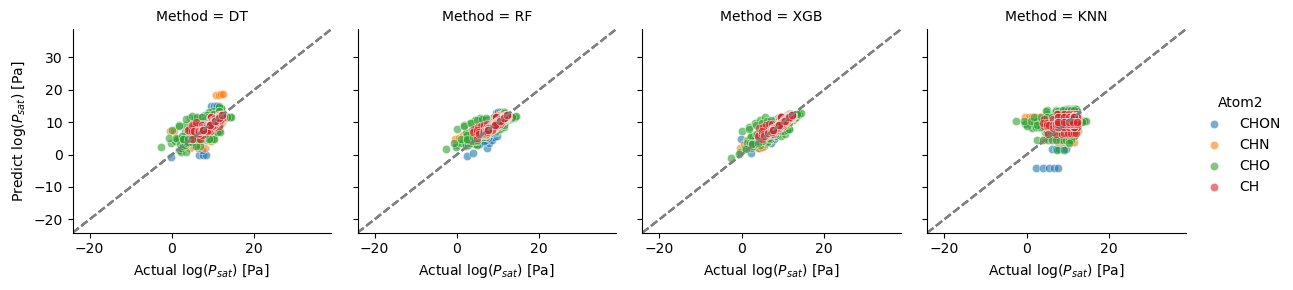

In [83]:
#%% Visualization
# Specified Range for plot
x_min = min(min(test_prediction_bestpar_visual["Test Predict"]),min(test_prediction_bestpar_visual["Test Actual"]))-20
x_max = max(max(test_prediction_bestpar_visual["Test Predict"]),max(test_prediction_bestpar_visual["Test Actual"]))+20
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction_bestpar_visual, col="Method", col_wrap=4, hue="Atom2")

g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
g.set_ylabels("Predict log($P_{sat}$) [Pa]")
#g.ylabel("$Predict P_{sat}$"))
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

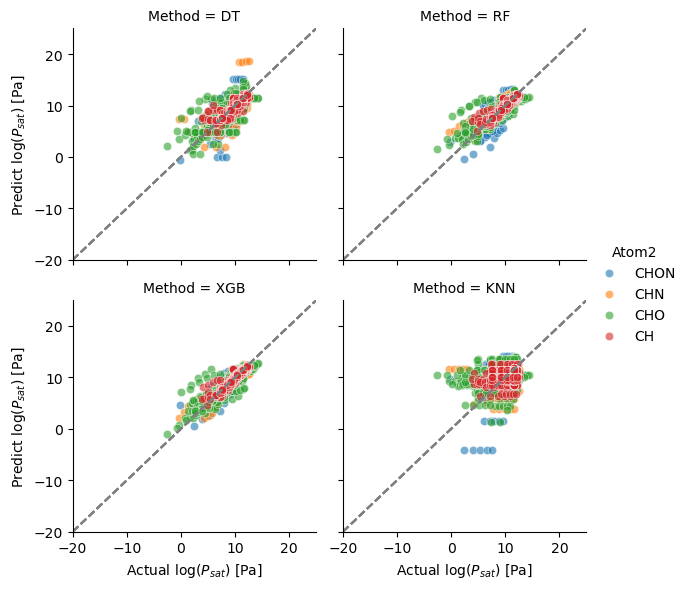

In [84]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(test_prediction_bestpar_visual, col="Method", col_wrap=2, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
g.set_ylabels("Predict log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [85]:
test_result = create_result_from_predict_value(result_test, func_name, func_list)
best_name = test_result[test_result["RMSE"]==min(test_result["RMSE"])]["Method"].iloc[0]
best_name

'XGB'

In [86]:
temp_graph = test_prediction_bestpar_visual[test_prediction_bestpar_visual["Method"]==best_name]
temp_graph

,Method,Test Predict,Test Actual,SMILES,Atom2
10,XGB,7.357635,6.428063,CCOC(=O)N,CHON
11,XGB,8.529598,8.058521,CCOC(=O)N,CHON
12,XGB,9.456140,9.409872,CCOC(=O)N,CHON
13,XGB,10.819680,10.548132,CCOC(=O)N,CHON
14,XGB,11.805124,11.520021,CCOC(=O)N,CHON
...,...,...,...,...,...
8850,XGB,3.367925,2.581252,CC(C(=O)OC(C)C(=O)OC)O,CHO
8851,XGB,3.528499,3.971663,CC(C(=O)OC(C)C(=O)OC)O,CHO
8852,XGB,5.450990,5.183165,CC(C(=O)OC(C)C(=O)OC)O,CHO
8853,XGB,6.171550,6.248203,CC(C(=O)OC(C)C(=O)OC)O,CHO


(-20.0, 25.0)

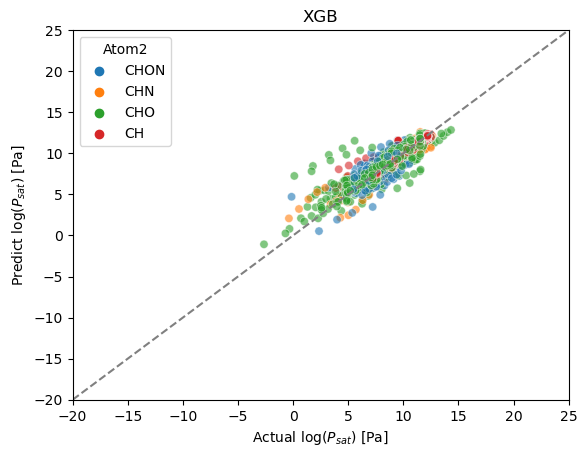

In [87]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

gc = sns.scatterplot(temp_graph, x="Test Actual", y="Test Predict", hue="Atom2", alpha=0.6)
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

# Add Legend, range of show
plt.title(best_name)
plt.xlabel("Actual log($P_{sat}$) [Pa]")
plt.ylabel("Predict log($P_{sat}$) [Pa]")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

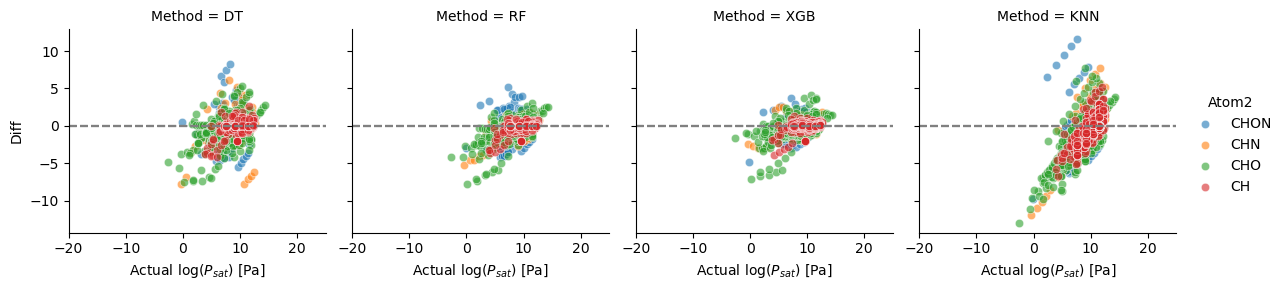

In [88]:
test_prediction_bestpar_visual["Diff"] = test_prediction_bestpar_visual["Test Actual"] - test_prediction_bestpar_visual["Test Predict"]
#sns.histplot(data=test_prediction_visual, x="Diff")

# Plot each method
g = sns.FacetGrid(test_prediction_bestpar_visual, col="Method", col_wrap=4, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Diff", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=0, color='.5', linestyle='--'))

g.add_legend()
plt.xlim(x_min, x_max)

(-20.0, 25.0)

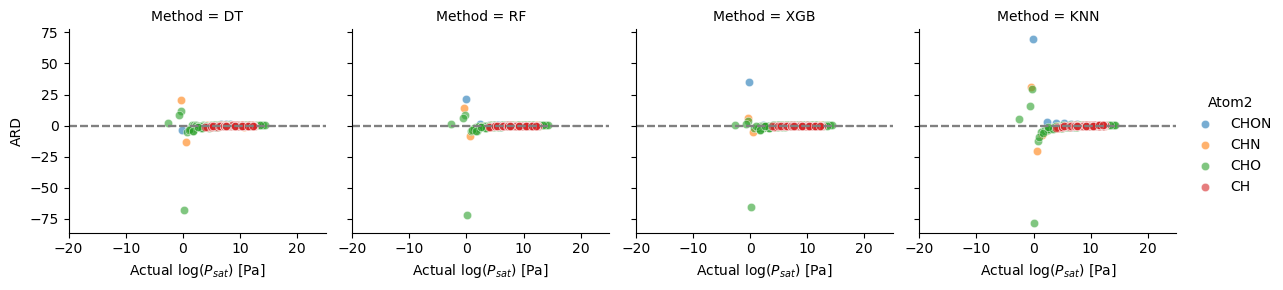

In [89]:
test_prediction_bestpar_visual["ARD"] = test_prediction_bestpar_visual["Diff"] / test_prediction_bestpar_visual["Test Actual"]

# Plot each method
g = sns.FacetGrid(test_prediction_bestpar_visual, col="Method", col_wrap=4, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="ARD", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=0, color='.5', linestyle='--'))

g.add_legend()
plt.xlim(x_min, x_max)
#plt.yscale('log')
#plt.ylim(-10, 10)

## Visualization_Train

In [35]:
train_prediction_bestpar_visual = train_prediction_bestpar.copy()
train_prediction_bestpar_visual[train_prediction_bestpar_visual["Training Actual"]<-20]
print(f'min = {min(train_prediction_bestpar_visual["Training Actual"])}  max = {max(train_prediction_bestpar_visual["Training Actual"])}')

min = -5.527856419558724  max = 15.198214449184213


(-25.527856419558724, 35.3515682220459)

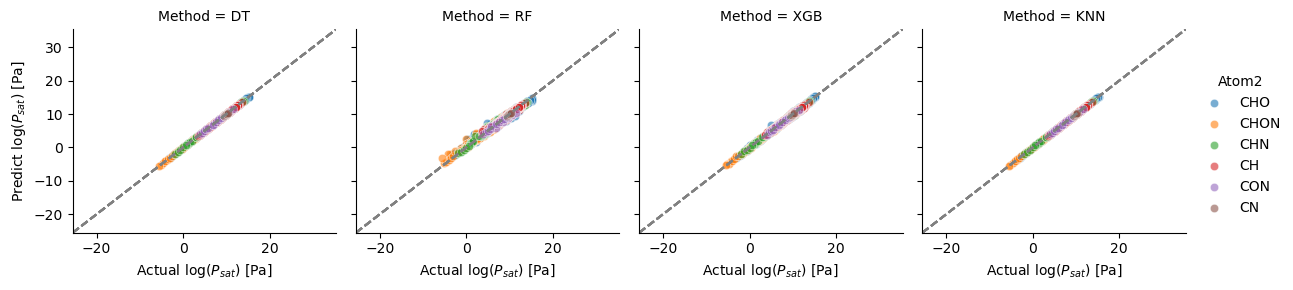

In [36]:
#%% Visualization
# Specified Range for plot
x_min = min(min(train_prediction_bestpar_visual["Training Predict"]),min(train_prediction_bestpar_visual["Training Actual"]))-20
x_max = max(max(train_prediction_bestpar_visual["Training Predict"]),max(train_prediction_bestpar_visual["Training Actual"]))+20
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(train_prediction_bestpar_visual, col="Method", col_wrap=4, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Training Actual", y="Training Predict", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
g.set_ylabels("Predict log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

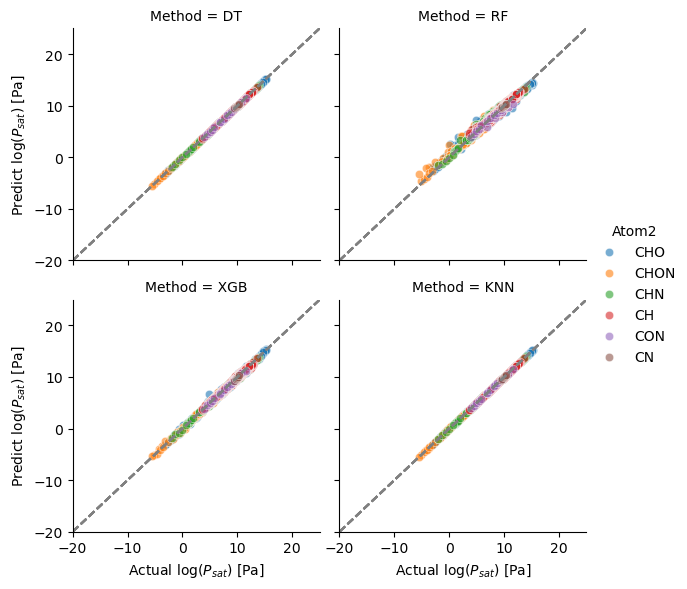

In [37]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(train_prediction_bestpar_visual, col="Method", col_wrap=2, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Training Actual", y="Training Predict", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
g.set_ylabels("Predict log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1, color='.5', linestyle='--'))

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-20.0, 25.0)

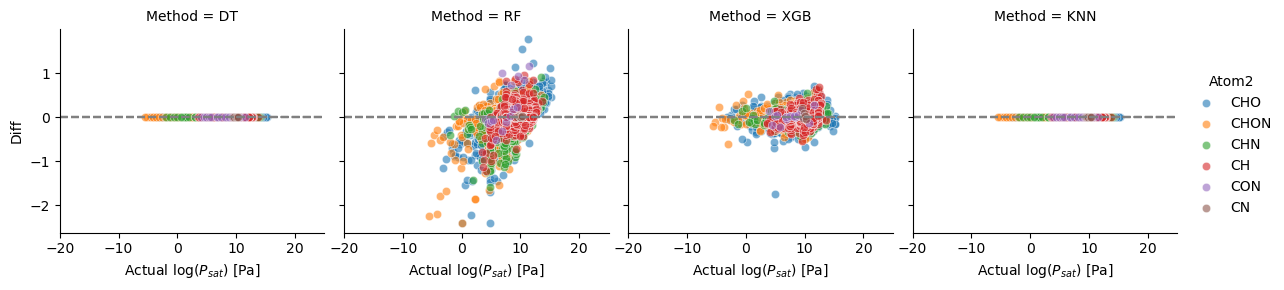

In [44]:
train_prediction_bestpar_visual["Diff"] = train_prediction_bestpar_visual["Training Actual"] - train_prediction_bestpar_visual["Training Predict"]
#sns.histplot(data=test_prediction_visual, x="Diff")

# Plot each method
g = sns.FacetGrid(train_prediction_bestpar_visual, col="Method", col_wrap=4, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Training Actual", y="Diff", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=0, color='.5', linestyle='--'))

g.add_legend()
plt.xlim(x_min, x_max)
#plt.ylim(-10, 10)

(-20.0, 25.0)

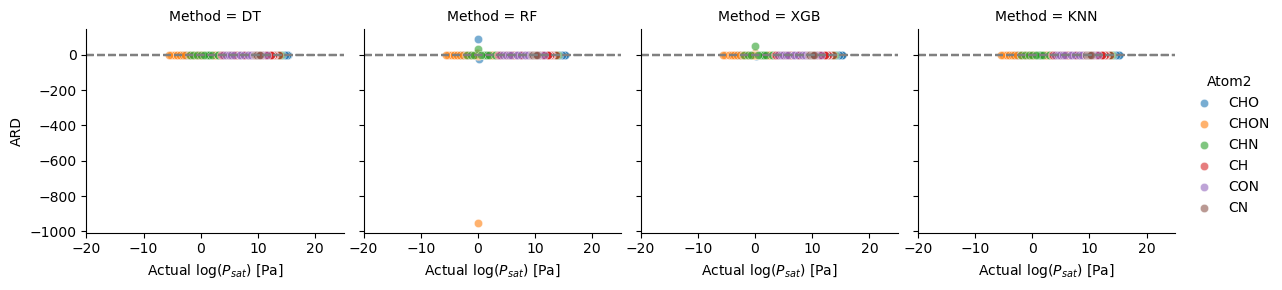

In [45]:
train_prediction_bestpar_visual["ARD"] = train_prediction_bestpar_visual["Diff"] / train_prediction_bestpar_visual["Training Actual"]

# Plot each method
g = sns.FacetGrid(train_prediction_bestpar_visual, col="Method", col_wrap=4, hue="Atom2")
g.map_dataframe(sns.scatterplot, x="Training Actual", y="ARD", alpha=0.6)
g.set_xlabels("Actual log($P_{sat}$) [Pa]")
# Insert Perfect Line
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=0, color='.5', linestyle='--'))

g.add_legend()
plt.xlim(x_min, x_max)
#plt.ylim(-10, 10)

# Send Line ML-Hyperparameter

In [41]:
import requests
url = 'https://notify-api.line.me/api/notify'
token = '3CfMWfczpal9Zye6bD72a8Ud6FWOODnBHQZHIWM1YU4'
headers = {'content-type':'application/x-www-form-urlencoded','Authorization':'Bearer '+token}

msg = f'run ML Hyperparameter+Normalization เสร็จแล้ว'
#r = requests.post(url, headers=headers, data = {'message':msg})
#print (r.text)


from discordwebhook import Discord
discord_sky = Discord(url="https://discord.com/api/webhooks/1199614974293717103/TBi5ecy1kOZoE1bOfiHoeygsRFS1DTIp-2-f4RjSaqLbQwBki6g7M2baYJX88igNBre9")
discord_sky.post(content="run ML Hyperparameter+Normalization เสร็จแล้ว")

<Response [204]>

# Save Result, Model

## Set up for Save

In [ ]:
# Set up
import datetime
date_run = datetime.datetime.now().strftime("%Y-%m-%d")

# Result Path
result_path1 = f"{date_run} Psat Psat train - SMILES T VP.csv"
result_path5 = f"{date_run} Psat Psat test - SMILES T VP.csv"

result_path2 = f"{date_run} Psat Psat test_prediction.csv"
result_path3 = f"{date_run} Psat Psat train_prediction.csv"
result_path4 = f"{date_run} Psat Psat result_evaluation.csv"

# Model Path
all_path_export = []
for name in names_bestpar:
  name_model = name
  model_template1 = f" Psat Psat {name_model}.joblib"
  model_template2 = f" Psat Psat {name_model}.pth"

  path_export = ""
  if("DL" not in name_model):
    path_export = model_template1
  else:
    path_export = model_template2
  path_export = date_run+path_export
  all_path_export.append(path_export)

## Set Up Download to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Result path
com_path = "/content/gdrive/MyDrive/for_ML-Project/For Save/"

com_result_path1 = com_path+ result_path1
com_result_path2 = com_path+ result_path2
com_result_path3 = com_path+ result_path3
com_result_path4 = com_path+ result_path4

## Model path
drive_model_all_path_export = []
for path_save in all_path_export:
  drive_export = com_path+path_save
  drive_model_all_path_export.append(drive_export)

MessageError: Error: credential propagation was unsuccessful

## Save & Download to Computer

### Save

In [ ]:
test_prediction_bestpar

,Method,Test Predict,Test Actual
0,DT,2.694676,7.588958
0,DT,4.420181,8.253706
0,DT,4.420181,8.870685
0,DT,7.135732,9.444863
0,DT,9.449868,9.980548
...,...,...,...
3,KNN,9.593447,9.089442
3,KNN,10.135162,9.615435
3,KNN,10.628326,10.098710
3,KNN,10.628332,10.544267


In [ ]:
train_prediction_bestpar

,Method,Training Predict,Training Actual
0,DT,7.581574,7.581574
0,DT,8.316537,8.316537
0,DT,8.977115,8.977115
0,DT,9.574057,9.574057
0,DT,10.116136,10.116136
...,...,...,...
3,KNN,5.082023,5.082025
3,KNN,5.654227,5.654228
3,KNN,6.194770,6.194771
3,KNN,6.706201,6.706214


In [ ]:
# Save Result
df2_train.to_csv(result_path1)
df2_test.to_csv(result_path5)

test_prediction_bestpar.to_csv(result_path2)
train_prediction_bestpar.to_csv(result_path3)
result_evaluation_bestpar.to_csv(result_path4)

In [ ]:
# Save Model
for i in range(len(all_path_export)):
  name = names_bestpar[i]
  model_export = all_result_model_bestpar[i]
  path = all_path_export[i]

  if("DL" not in name):
    dump(model_export, path)
  else:
    torch.save(model_export.state_dict(), path)
#loaded_model = load("my_model.joblib")

In [ ]:
# Line Notify
msg = f'Save Model Hyperparameter+Normalization เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


### Download to computer

In [ ]:
all_path_export

['2024-01-29 Psat Psat DT.joblib',
 '2024-01-29 Psat Psat RF.joblib',
 '2024-01-29 Psat Psat XGB.joblib',
 '2024-01-29 Psat Psat KNN.joblib']

In [ ]:
from google.colab import files
# Download SMILES T Psat
files.download(result_path1)
files.download(result_path5)

# Download Result Prediction
files.download(result_path2)
files.download(result_path3)
files.download(result_path4)

# Download Model
for path in all_path_export:
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Line Notify
msg = f'download Model Hyperparameter+Normalization เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


## Save to Drive

### Save

In [ ]:
# Save Result to Drive
df2.to_csv(com_result_path1)
test_prediction.to_csv(com_result_path2)
train_prediction.to_csv(com_result_path3)
result_evaluation.to_csv(com_result_path4)

In [ ]:
# Save Model
for i in range(len(drive_model_all_path_export)):
  name = names[i]
  model_export = all_result_model[i]
  path = drive_model_all_path_export[i]

  if("DL" not in name):
    dump(model_export, path)
  else:
    torch.save(model_export.state_dict(), path)
#loaded_model = load("my_model.joblib")

In [ ]:
msg = f'download ลง drive เรียบร้อย'
r = requests.post(url, headers=headers, data = {'message':msg})
print (r.text)

{"status":200,"message":"ok"}


# Visualization From File

In [ ]:
# Get result from Model that just got
test_prediction = pd.read_csv("/content/2024-01-03 Psat Psat test_prediction.csv")
train_prediction = pd.read_csv("/content/2024-01-03 Psat Psat train_prediction.csv")
result_evaluation = pd.read_csv("/content/2024-01-03 Psat Psat result_evaluation.csv")

# Get result from Github
#test_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat test_prediction.csv")
#train_prediction = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat train_prediction.csv")
#result_evaluation = pd.read_csv("/content/SMILE_to_Feature/Second Semester/For Present/2024-01-04/2024-01-02 Psat Psat result_evaluation.csv")

In [ ]:
# Change Data that can show Error Metric in each plot
result_evaluation_merge = result_evaluation[["Method","Test RMSE", "Test R2"]]
merged_df = test_prediction.merge(result_evaluation_merge, on='Method', how='inner')  # Inner join
merged_df

,Unnamed: 0,Method,Test Predict,Test Actual,Test RMSE,Test R2
0,0,XGB,10.007981,8.397664,78.518016,-0.060755
1,0,XGB,8.948020,7.725961,78.518016,-0.060755
2,0,XGB,8.671771,1.416442,78.518016,-0.060755
3,0,XGB,8.948020,5.016796,78.518016,-0.060755
4,0,XGB,8.968746,7.362200,78.518016,-0.060755
...,...,...,...,...,...,...
15267,3,DL2,-17.290596,1.133479,75.797770,0.011471
15268,3,DL2,11.440319,8.319116,75.797770,0.011471
15269,3,DL2,9.888784,11.073348,75.797770,0.011471
15270,3,DL2,11.448484,8.341905,75.797770,0.011471


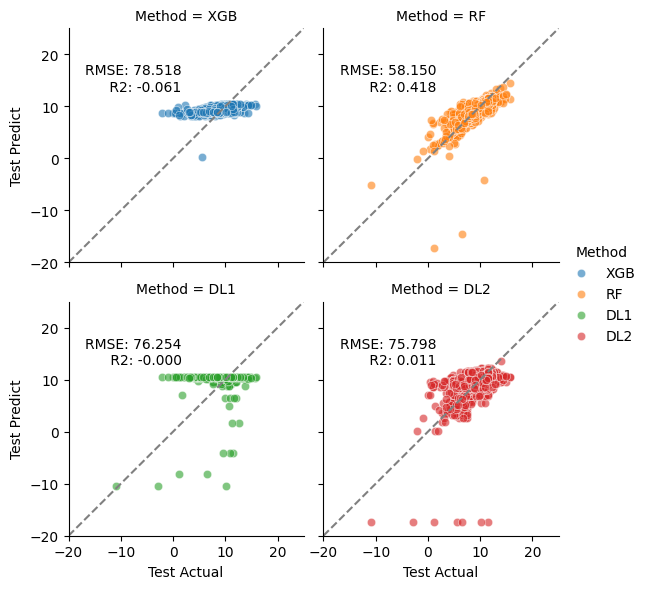

In [ ]:
# Specified Range for plot
x_min = -20; x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
g = sns.FacetGrid(merged_df, col="Method", col_wrap=2, hue="Method")
g.map_dataframe(sns.scatterplot, x="Test Actual", y="Test Predict", alpha=0.6)

# Insert Perfect Line and Error Metric
def plot_with_text2(data, **kws):
    plt.axline((0, 0), slope=1, color='.5', linestyle='--')
    # Access the current subplot and add text
    current_ax = plt.gca()
    current_ax.text(0.5, 0.85, f"RMSE: {data['Test RMSE'].iloc[0]:.3f} \n R2: {data['Test R2'].iloc[0]:.3f} ",
                    transform=current_ax.transAxes, ha='right', va='top')
g.map_dataframe(plot_with_text2)

# Add Legend, range of show
g.add_legend()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# ABC From File

In [90]:
temp_Psat_actual_file = df2_test.copy()
temp_Psat_actual_file

,index,SMILES,T,Vapor_Presssure
0,0,CCOC(=O)N,338.00,6.428063
1,1,CCOC(=O)N,367.75,8.058521
2,2,CCOC(=O)N,397.50,9.409872
3,3,CCOC(=O)N,427.25,10.548132
4,4,CCOC(=O)N,457.00,11.520021
...,...,...,...,...
2210,2210,CC(C(=O)OC(C)C(=O)OC)O,317.00,2.581252
2211,2211,CC(C(=O)OC(C)C(=O)OC)O,333.75,3.971663
2212,2212,CC(C(=O)OC(C)C(=O)OC)O,350.50,5.183165
2213,2213,CC(C(=O)OC(C)C(=O)OC)O,367.25,6.248203


In [91]:
#From Test Prediction /
#prediction_file = pd.read_csv("/content/2024-01-29 Psat Psat test_prediction.csv")
test_result = create_result_from_predict_value(result_test, func_name, func_list)
best_name = test_result[test_result["RMSE"]==min(test_result["RMSE"])]["Method"].iloc[0]
prediction_file = test_prediction_bestpar[test_prediction_bestpar["Method"]==best_name][["Test Predict", "Test Actual"]].reset_index(drop=True)
prediction_file

,Test Predict,Test Actual
0,7.357635,6.428063
1,8.529598,8.058521
2,9.456140,9.409872
3,10.819680,10.548132
4,11.805124,11.520021
...,...,...
2210,3.367925,2.581252
2211,3.528499,3.971663
2212,5.450990,5.183165
2213,6.171550,6.248203


In [92]:
df3 = pd.concat([temp_Psat_actual_file, prediction_file], axis = 1)
df3

,index,SMILES,T,Vapor_Presssure,Test Predict,Test Actual
0,0,CCOC(=O)N,338.00,6.428063,7.357635,6.428063
1,1,CCOC(=O)N,367.75,8.058521,8.529598,8.058521
2,2,CCOC(=O)N,397.50,9.409872,9.456140,9.409872
3,3,CCOC(=O)N,427.25,10.548132,10.819680,10.548132
4,4,CCOC(=O)N,457.00,11.520021,11.805124,11.520021
...,...,...,...,...,...,...
2210,2210,CC(C(=O)OC(C)C(=O)OC)O,317.00,2.581252,3.367925,2.581252
2211,2211,CC(C(=O)OC(C)C(=O)OC)O,333.75,3.971663,3.528499,3.971663
2212,2212,CC(C(=O)OC(C)C(=O)OC)O,350.50,5.183165,5.450990,5.183165
2213,2213,CC(C(=O)OC(C)C(=O)OC)O,367.25,6.248203,6.171550,6.248203


In [93]:
result = df3.groupby('SMILES', sort=False)[['T', 'Test Predict', 'Test Actual']].agg(list)
# Reset the index to create a DataFrame
result = result.reset_index()
result

,SMILES,T,Test Predict,Test Actual
0,CCOC(=O)N,"[338.0, 367.75, 397.5, 427.25, 457.0]","[7.357634544372559, 8.529598236083984, 9.45613...","[6.4280627652619735, 8.058521037507104, 9.4098..."
1,CN1CCC[C@H]1C2=CN=CC=C2,"[334.0, 380.75, 427.5, 474.25, 521.0]","[5.126888275146484, 8.462697982788086, 10.8443...","[4.848526496676478, 7.211622438416432, 9.00071..."
2,CCOC1=CC=C(C=C1)NC(=O)C,"[465.0, 481.0, 497.0, 513.0, 529.0]","[8.673296928405762, 9.210519790649414, 9.66815...","[6.506107278595692, 7.218962852259455, 7.87932..."
3,CCCO,"[293.0, 309.75, 326.5, 343.25, 360.0]","[8.557583808898926, 8.468958854675293, 9.14171...","[7.587730888929535, 8.654470048854394, 9.58331..."
4,C#N,"[261.0, 270.75, 280.5, 290.25, 300.0]","[9.339292526245117, 10.16918659210205, 10.1590...","[9.892362405001142, 10.359304896298115, 10.791..."
...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,"[418.0, 441.25, 464.5, 487.75, 511.0]","[7.019151210784912, 8.059986114501953, 9.05126...","[5.552116796832745, 6.668856658479452, 7.67381..."
439,CCCOC(=O)CCO,"[350.0, 356.25, 362.5, 368.75, 375.0]","[7.500749111175537, 7.624433994293213, 8.04196...","[6.492303140060496, 6.859562576948068, 7.21415..."
440,CCCCOC(=O)CCO,"[361.0, 393.25, 425.5, 457.75, 490.0]","[7.002391338348389, 8.653209686279297, 9.26817...","[6.494381668953714, 8.122745339493003, 9.45817..."
441,COC(=O)CCCCC(=O)CCC(=O)OC,"[394.0, 435.25, 476.5, 517.75, 559.0]","[5.246408462524414, 7.07573938369751, 8.694812...","[4.957713176279768, 7.060162739573535, 8.80090..."


In [95]:
#result2.head(2)

In [96]:
x = result["T"].apply(lambda num: [1/num1 for num1 in num])
y = result["Test Predict"]

xy_table = pd.DataFrame({
    "x" : x,
    "y" : y})

result2 = result.join(xy_table)
#%%
from scipy.optimize import curve_fit
def objective(X, a, b, c):
    x,y = X
    # Linearized Equation : y + C * y * x1 = A + B * x1
    # return a +(b*x) - (c*y*x)

    # Linearized Equation : logP = A + (AC-B) (1/T) +  (-C) (logP /T)
    a0 = a
    a1 = a*c - b
    a2 = -c
    x1 = x
    x2 = y*x
    return a0 + a1*x1 + a2*x2

def getABC(row):
    #print(row.x)
    x1 = row.x
    y1 = row.y
    popt, _ = curve_fit(objective, (x1,y1), y1, p0=[20, 2000, 0], method="lm")
    a,b,c = popt
    return [a,b,c]
#z = func((x,y), a, b, c) * 1
result2["ABC"] = result2.apply(getABC, axis=1)
result2[['A_Pred', 'B_Pred', 'C_Pred']] = pd.DataFrame(result2['ABC'].tolist())


x_test = result["T"].apply(lambda num: [1/num1 for num1 in num])
y_test = result["Test Actual"]
xy_test_table = pd.DataFrame({
    "x_test" : x_test,
    "y_test" : y_test})
result2 = result2.join(xy_test_table)
def getABC2(row):
    #print(row.x)
    x1 = row.x_test
    y1 = row.y_test
    popt, _ = curve_fit(objective, (x1,y1), y1, p0=[20, 2000, 60], method="lm")
    a,b,c = popt
    return [a,b,c]
result2["ABC_test"] = result2.apply(getABC2, axis=1)
result2[['A_test', 'B_test', 'C_test']] = pd.DataFrame(result2['ABC_test'].tolist())
result2

result3 = result2[["SMILES", "A_Pred", "B_Pred", "C_Pred", "A_test", "B_test", "C_test"]]
result3

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.920000
1,CN1CCC[C@H]1C2=CN=CC=C2,16.273930,1077.069901,-238.504544,21.942531,4981.654362,-42.573000
2,CCOC1=CC=C(C=C1)NC(=O)C,11.969128,207.881475,-403.554234,25.155166,7507.682312,-62.423000
3,CCCO,8.098686,33.804930,-370.253270,23.025644,3483.673091,-67.343000
4,C#N,10.614496,7.583709,-255.573280,21.886463,2886.895994,-20.307000
...,...,...,...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,12.880209,514.944347,-331.314165,26.749569,8862.039838,0.071000
439,CCCOC(=O)CCO,8.225211,-2.080669,-356.808830,27.426091,7326.825666,-0.000002
440,CCCCOC(=O)CCO,14.336315,866.044509,-243.884546,22.969484,4844.371936,-66.958000
441,COC(=O)CCCCC(=O)CCC(=O)OC,42.989481,29436.105486,384.942932,27.296686,8869.465675,3.040000


In [97]:
#df_initial = pd.read_csv(r"C:/Users\Kan\Documents/GitHub\SMILE_to_Feature\Second Semester\[Use] Main File\RDKit_CHON_New_Data_Psat_Not_Outliers.csv")
df_initial = df.copy()
df_for_lookup = df_initial.copy()

final = result3.merge(df_for_lookup, on="SMILES")
#final = result3.join(df_for_lookup, on="SMILES")
final = pd.concat([result3, df_for_lookup[["A", "B", "C", "Atom2"]]], axis=1, join="inner")
#print(final.describe())
final2 = pd.concat([final, result["T"]], axis=1, join="inner")
final2

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.920000,21.370292,2204.126554,-30.150,CHO,"[338.0, 367.75, 397.5, 427.25, 457.0]"
1,CN1CCC[C@H]1C2=CN=CC=C2,16.273930,1077.069901,-238.504544,21.942531,4981.654362,-42.573000,23.846838,5018.000667,-49.920,CHON,"[334.0, 380.75, 427.5, 474.25, 521.0]"
2,CCOC1=CC=C(C=C1)NC(=O)C,11.969128,207.881475,-403.554234,25.155166,7507.682312,-62.423000,21.942531,4981.654362,-42.573,CHN,"[465.0, 481.0, 497.0, 513.0, 529.0]"
3,CCCO,8.098686,33.804930,-370.253270,23.025644,3483.673091,-67.343000,21.660004,4547.838120,-113.651,CHON,"[293.0, 309.75, 326.5, 343.25, 360.0]"
4,C#N,10.614496,7.583709,-255.573280,21.886463,2886.895994,-20.307000,24.322575,6153.389259,-81.155,CHO,"[261.0, 270.75, 280.5, 290.25, 300.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,12.880209,514.944347,-331.314165,26.749569,8862.039838,0.071000,20.960064,3325.450956,-117.677,CHO,"[418.0, 441.25, 464.5, 487.75, 511.0]"
439,CCCOC(=O)CCO,8.225211,-2.080669,-356.808830,27.426091,7326.825666,-0.000002,20.481080,2287.569936,-53.401,CHO,"[350.0, 356.25, 362.5, 368.75, 375.0]"
440,CCCCOC(=O)CCO,14.336315,866.044509,-243.884546,22.969484,4844.371936,-66.958000,22.686450,4080.411043,-83.150,CHO,"[361.0, 393.25, 425.5, 457.75, 490.0]"
441,COC(=O)CCCCC(=O)CCC(=O)OC,42.989481,29436.105486,384.942932,27.296686,8869.465675,3.040000,20.171659,3092.233625,-158.382,CHO,"[394.0, 435.25, 476.5, 517.75, 559.0]"


In [98]:
final3 = final2.merge(result[["SMILES", "Test Predict", "Test Actual"]], on="SMILES")
def cb2(row):
    #print(row["Test Actual"])
    return  rmse_func(row["Test Actual"], row["Test Predict"])
final3["RMSE"] = final3.apply(lambda x : cb2(x), axis=1)
final3

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.920000,21.370292,2204.126554,-30.150,CHO,"[338.0, 367.75, 397.5, 427.25, 457.0]","[7.357634544372559, 8.529598236083984, 9.45613...","[6.4280627652619735, 8.058521037507104, 9.4098...",0.498634
1,CN1CCC[C@H]1C2=CN=CC=C2,16.273930,1077.069901,-238.504544,21.942531,4981.654362,-42.573000,23.846838,5018.000667,-49.920,CHON,"[334.0, 380.75, 427.5, 474.25, 521.0]","[5.126888275146484, 8.462697982788086, 10.8443...","[4.848526496676478, 7.211622438416432, 9.00071...",1.201574
2,CCOC1=CC=C(C=C1)NC(=O)C,11.969128,207.881475,-403.554234,25.155166,7507.682312,-62.423000,21.942531,4981.654362,-42.573,CHN,"[465.0, 481.0, 497.0, 513.0, 529.0]","[8.673296928405762, 9.210519790649414, 9.66815...","[6.506107278595692, 7.218962852259455, 7.87932...",1.796735
3,CCCO,8.098686,33.804930,-370.253270,23.025644,3483.673091,-67.343000,21.660004,4547.838120,-113.651,CHON,"[293.0, 309.75, 326.5, 343.25, 360.0]","[8.557583808898926, 8.468958854675293, 9.14171...","[7.587730888929535, 8.654470048854394, 9.58331...",0.658036
4,C#N,10.614496,7.583709,-255.573280,21.886463,2886.895994,-20.307000,24.322575,6153.389259,-81.155,CHO,"[261.0, 270.75, 280.5, 290.25, 300.0]","[9.339292526245117, 10.16918659210205, 10.1590...","[9.892362405001142, 10.359304896298115, 10.791...",0.711172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,12.880209,514.944347,-331.314165,26.749569,8862.039838,0.071000,20.960064,3325.450956,-117.677,CHO,"[418.0, 441.25, 464.5, 487.75, 511.0]","[7.019151210784912, 8.059986114501953, 9.05126...","[5.552116796832745, 6.668856658479452, 7.67381...",1.218566
439,CCCOC(=O)CCO,8.225211,-2.080669,-356.808830,27.426091,7326.825666,-0.000002,20.481080,2287.569936,-53.401,CHO,"[350.0, 356.25, 362.5, 368.75, 375.0]","[7.500749111175537, 7.624433994293213, 8.04196...","[6.492303140060496, 6.859562576948068, 7.21415...",0.808823
440,CCCCOC(=O)CCO,14.336315,866.044509,-243.884546,22.969484,4844.371936,-66.958000,22.686450,4080.411043,-83.150,CHO,"[361.0, 393.25, 425.5, 457.75, 490.0]","[7.002391338348389, 8.653209686279297, 9.26817...","[6.494381668953714, 8.122745339493003, 9.45817...",0.450143
441,COC(=O)CCCCC(=O)CCC(=O)OC,42.989481,29436.105486,384.942932,27.296686,8869.465675,3.040000,20.171659,3092.233625,-158.382,CHO,"[394.0, 435.25, 476.5, 517.75, 559.0]","[5.246408462524414, 7.07573938369751, 8.694812...","[4.957713176279768, 7.060162739573535, 8.80090...",0.212912


In [99]:
def do_plot(rmse, is_plot, count, thereshold=1):
    #print(rmse)
    if rmse_predict >= thereshold:
        count+=1
        if is_plot :
            x1 = temp["T"]
            x2 = temp["T"]

            y1 = temp["Test Actual"]
            y2 = temp["Test Predict"]

            smiles = temp["SMILES"]
            
            # Mention x and y limits to define their range
            plt.xlim(0, 700)
            plt.ylim(-5, 20)

            # Plotting graph
            plt.scatter(x1, y1, alpha=0.6)
            plt.plot(x2, y2, alpha=0.6)

            #g.set_xlabels("Actual log($P_{sat}$) [Pa]")
            #g.set_ylabels("Predict log($P_{sat}$) [Pa]")

            #plt.axline((0, 0), slope=1, color='.5', linestyle='--')
            temp_T = temp["T"]
            t = f'T = {min(temp_T):0.1f} - {max(temp_T):0.1f} K'
            abc = f'Actual  : A = {temp["A"]:0.3f}, B = {temp["B"]:0.4f},  C = {temp["C"]:0.2f}'
            p_abc = f'Predict : A = {temp["A_Pred"]:0.3f}, B = {temp["B_Pred"]:0.4f},  C = {temp["C_Pred"]:0.2f}'


            plt.text(10,19,f'sub: {i}')
            plt.text(6,17,smiles)
            plt.text(6,15,t)
            plt.text(6,13,f'rmse = {rmse_predict:0.3f}')
            plt.text(200, 19, abc)
            plt.text(200, 18, p_abc)

            plt.grid()

            #filename = f'2024-02-13 image/figure {i+1}.png'
            #filenames.append(filename)
            #plt.savefig(filename, bbox_inches='tight')

            plt.pause(0.01)

            plt.show()
            plt.xlabel = "Actual log($P_{sat}$) [Pa]"
            plt.ylabel = "Predict log($P_{sat}$) [Pa]"
            plt.close("all")
    return count

In [100]:
from matplotlib import pyplot as plt

filenames = []
count=0
thereshold_input=2
for i in range(len(result)):
    temp = final3.iloc[i]
    rmse_predict = temp["RMSE"]
    count = do_plot(rmse_predict, False, count, thereshold=thereshold_input)

In [101]:
(len(result), count)

(443, 13)

In [102]:
final3

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.920000,21.370292,2204.126554,-30.150,CHO,"[338.0, 367.75, 397.5, 427.25, 457.0]","[7.357634544372559, 8.529598236083984, 9.45613...","[6.4280627652619735, 8.058521037507104, 9.4098...",0.498634
1,CN1CCC[C@H]1C2=CN=CC=C2,16.273930,1077.069901,-238.504544,21.942531,4981.654362,-42.573000,23.846838,5018.000667,-49.920,CHON,"[334.0, 380.75, 427.5, 474.25, 521.0]","[5.126888275146484, 8.462697982788086, 10.8443...","[4.848526496676478, 7.211622438416432, 9.00071...",1.201574
2,CCOC1=CC=C(C=C1)NC(=O)C,11.969128,207.881475,-403.554234,25.155166,7507.682312,-62.423000,21.942531,4981.654362,-42.573,CHN,"[465.0, 481.0, 497.0, 513.0, 529.0]","[8.673296928405762, 9.210519790649414, 9.66815...","[6.506107278595692, 7.218962852259455, 7.87932...",1.796735
3,CCCO,8.098686,33.804930,-370.253270,23.025644,3483.673091,-67.343000,21.660004,4547.838120,-113.651,CHON,"[293.0, 309.75, 326.5, 343.25, 360.0]","[8.557583808898926, 8.468958854675293, 9.14171...","[7.587730888929535, 8.654470048854394, 9.58331...",0.658036
4,C#N,10.614496,7.583709,-255.573280,21.886463,2886.895994,-20.307000,24.322575,6153.389259,-81.155,CHO,"[261.0, 270.75, 280.5, 290.25, 300.0]","[9.339292526245117, 10.16918659210205, 10.1590...","[9.892362405001142, 10.359304896298115, 10.791...",0.711172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,12.880209,514.944347,-331.314165,26.749569,8862.039838,0.071000,20.960064,3325.450956,-117.677,CHO,"[418.0, 441.25, 464.5, 487.75, 511.0]","[7.019151210784912, 8.059986114501953, 9.05126...","[5.552116796832745, 6.668856658479452, 7.67381...",1.218566
439,CCCOC(=O)CCO,8.225211,-2.080669,-356.808830,27.426091,7326.825666,-0.000002,20.481080,2287.569936,-53.401,CHO,"[350.0, 356.25, 362.5, 368.75, 375.0]","[7.500749111175537, 7.624433994293213, 8.04196...","[6.492303140060496, 6.859562576948068, 7.21415...",0.808823
440,CCCCOC(=O)CCO,14.336315,866.044509,-243.884546,22.969484,4844.371936,-66.958000,22.686450,4080.411043,-83.150,CHO,"[361.0, 393.25, 425.5, 457.75, 490.0]","[7.002391338348389, 8.653209686279297, 9.26817...","[6.494381668953714, 8.122745339493003, 9.45817...",0.450143
441,COC(=O)CCCCC(=O)CCC(=O)OC,42.989481,29436.105486,384.942932,27.296686,8869.465675,3.040000,20.171659,3092.233625,-158.382,CHO,"[394.0, 435.25, 476.5, 517.75, 559.0]","[5.246408462524414, 7.07573938369751, 8.694812...","[4.957713176279768, 7.060162739573535, 8.80090...",0.212912


In [103]:
#final3["over"] = final3[
#final3["RMSE"]>=thereshold_input
#final3.loc[final3["RMSE"]>=thereshold_input, "RMSE2"] = "Pass"
final3["RMSE2"] = np.where(final3["RMSE"] <= thereshold_input, "Pass", "NOT")
#final3[["SMILES","RMSE2"]]
final3

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE,RMSE2
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.920000,21.370292,2204.126554,-30.150,CHO,"[338.0, 367.75, 397.5, 427.25, 457.0]","[7.357634544372559, 8.529598236083984, 9.45613...","[6.4280627652619735, 8.058521037507104, 9.4098...",0.498634,Pass
1,CN1CCC[C@H]1C2=CN=CC=C2,16.273930,1077.069901,-238.504544,21.942531,4981.654362,-42.573000,23.846838,5018.000667,-49.920,CHON,"[334.0, 380.75, 427.5, 474.25, 521.0]","[5.126888275146484, 8.462697982788086, 10.8443...","[4.848526496676478, 7.211622438416432, 9.00071...",1.201574,Pass
2,CCOC1=CC=C(C=C1)NC(=O)C,11.969128,207.881475,-403.554234,25.155166,7507.682312,-62.423000,21.942531,4981.654362,-42.573,CHN,"[465.0, 481.0, 497.0, 513.0, 529.0]","[8.673296928405762, 9.210519790649414, 9.66815...","[6.506107278595692, 7.218962852259455, 7.87932...",1.796735,Pass
3,CCCO,8.098686,33.804930,-370.253270,23.025644,3483.673091,-67.343000,21.660004,4547.838120,-113.651,CHON,"[293.0, 309.75, 326.5, 343.25, 360.0]","[8.557583808898926, 8.468958854675293, 9.14171...","[7.587730888929535, 8.654470048854394, 9.58331...",0.658036,Pass
4,C#N,10.614496,7.583709,-255.573280,21.886463,2886.895994,-20.307000,24.322575,6153.389259,-81.155,CHO,"[261.0, 270.75, 280.5, 290.25, 300.0]","[9.339292526245117, 10.16918659210205, 10.1590...","[9.892362405001142, 10.359304896298115, 10.791...",0.711172,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,12.880209,514.944347,-331.314165,26.749569,8862.039838,0.071000,20.960064,3325.450956,-117.677,CHO,"[418.0, 441.25, 464.5, 487.75, 511.0]","[7.019151210784912, 8.059986114501953, 9.05126...","[5.552116796832745, 6.668856658479452, 7.67381...",1.218566,Pass
439,CCCOC(=O)CCO,8.225211,-2.080669,-356.808830,27.426091,7326.825666,-0.000002,20.481080,2287.569936,-53.401,CHO,"[350.0, 356.25, 362.5, 368.75, 375.0]","[7.500749111175537, 7.624433994293213, 8.04196...","[6.492303140060496, 6.859562576948068, 7.21415...",0.808823,Pass
440,CCCCOC(=O)CCO,14.336315,866.044509,-243.884546,22.969484,4844.371936,-66.958000,22.686450,4080.411043,-83.150,CHO,"[361.0, 393.25, 425.5, 457.75, 490.0]","[7.002391338348389, 8.653209686279297, 9.26817...","[6.494381668953714, 8.122745339493003, 9.45817...",0.450143,Pass
441,COC(=O)CCCCC(=O)CCC(=O)OC,42.989481,29436.105486,384.942932,27.296686,8869.465675,3.040000,20.171659,3092.233625,-158.382,CHO,"[394.0, 435.25, 476.5, 517.75, 559.0]","[5.246408462524414, 7.07573938369751, 8.694812...","[4.957713176279768, 7.060162739573535, 8.80090...",0.212912,Pass


In [104]:
final3

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE,RMSE2
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.920000,21.370292,2204.126554,-30.150,CHO,"[338.0, 367.75, 397.5, 427.25, 457.0]","[7.357634544372559, 8.529598236083984, 9.45613...","[6.4280627652619735, 8.058521037507104, 9.4098...",0.498634,Pass
1,CN1CCC[C@H]1C2=CN=CC=C2,16.273930,1077.069901,-238.504544,21.942531,4981.654362,-42.573000,23.846838,5018.000667,-49.920,CHON,"[334.0, 380.75, 427.5, 474.25, 521.0]","[5.126888275146484, 8.462697982788086, 10.8443...","[4.848526496676478, 7.211622438416432, 9.00071...",1.201574,Pass
2,CCOC1=CC=C(C=C1)NC(=O)C,11.969128,207.881475,-403.554234,25.155166,7507.682312,-62.423000,21.942531,4981.654362,-42.573,CHN,"[465.0, 481.0, 497.0, 513.0, 529.0]","[8.673296928405762, 9.210519790649414, 9.66815...","[6.506107278595692, 7.218962852259455, 7.87932...",1.796735,Pass
3,CCCO,8.098686,33.804930,-370.253270,23.025644,3483.673091,-67.343000,21.660004,4547.838120,-113.651,CHON,"[293.0, 309.75, 326.5, 343.25, 360.0]","[8.557583808898926, 8.468958854675293, 9.14171...","[7.587730888929535, 8.654470048854394, 9.58331...",0.658036,Pass
4,C#N,10.614496,7.583709,-255.573280,21.886463,2886.895994,-20.307000,24.322575,6153.389259,-81.155,CHO,"[261.0, 270.75, 280.5, 290.25, 300.0]","[9.339292526245117, 10.16918659210205, 10.1590...","[9.892362405001142, 10.359304896298115, 10.791...",0.711172,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,CCOC(=O)[C@H]1CCC(=O)N1,12.880209,514.944347,-331.314165,26.749569,8862.039838,0.071000,20.960064,3325.450956,-117.677,CHO,"[418.0, 441.25, 464.5, 487.75, 511.0]","[7.019151210784912, 8.059986114501953, 9.05126...","[5.552116796832745, 6.668856658479452, 7.67381...",1.218566,Pass
439,CCCOC(=O)CCO,8.225211,-2.080669,-356.808830,27.426091,7326.825666,-0.000002,20.481080,2287.569936,-53.401,CHO,"[350.0, 356.25, 362.5, 368.75, 375.0]","[7.500749111175537, 7.624433994293213, 8.04196...","[6.492303140060496, 6.859562576948068, 7.21415...",0.808823,Pass
440,CCCCOC(=O)CCO,14.336315,866.044509,-243.884546,22.969484,4844.371936,-66.958000,22.686450,4080.411043,-83.150,CHO,"[361.0, 393.25, 425.5, 457.75, 490.0]","[7.002391338348389, 8.653209686279297, 9.26817...","[6.494381668953714, 8.122745339493003, 9.45817...",0.450143,Pass
441,COC(=O)CCCCC(=O)CCC(=O)OC,42.989481,29436.105486,384.942932,27.296686,8869.465675,3.040000,20.171659,3092.233625,-158.382,CHO,"[394.0, 435.25, 476.5, 517.75, 559.0]","[5.246408462524414, 7.07573938369751, 8.694812...","[4.957713176279768, 7.060162739573535, 8.80090...",0.212912,Pass


In [105]:
final3_notpass = final3[final3["RMSE2"]=="NOT"]

In [106]:
final3_notpass

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE,RMSE2
33,CC(=O)C1=CC=C(C=C1)OC,5.396136,-0.381184,-313.814050,27.245162,8004.569450,0.000109,23.311763,5274.025104,-44.106,CHON,"[312.0, 317.25, 322.5, 327.75, 333.0]","[4.574366569519043, 4.952439308166504, 5.45132...","[1.5894998771704572, 2.0140615277664837, 2.424...",2.780519,NOT
72,CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=...,10.074199,353.197633,-297.700097,21.652037,5046.921136,-121.400000,23.243445,4402.082181,-59.350,CHO,"[353.0, 395.5, 438.0, 480.5, 523.0]","[4.708639621734619, 5.831725597381592, 7.36501...","[-0.13950547828115845, 3.239336318980243, 5.71...",2.568053,NOT
77,C=CCOCC(CO)O,8.613472,88.785460,-297.455017,21.837970,4287.887776,-104.561000,21.565759,4810.894651,-71.070,CH,"[323.0, 338.0, 353.0, 368.0, 383.0]","[5.573963642120361, 6.3698015213012695, 6.6281...","[2.2082898203033245, 3.469626646155845, 4.5786...",2.397647,NOT
80,CCCCCCCC(=O)O,20.433297,2676.293594,-215.259477,21.777090,6218.573140,-130.000000,20.029520,3622.387724,-133.336,CHO,"[417.0, 441.25, 465.5, 489.75, 514.0]","[7.2479023933410645, 8.461447715759277, 9.8092...","[0.10958772660238303, 1.797738502743666, 3.241...",6.500103,NOT
93,C1CCC2(CC1)CCCCC2,10.796526,97.704055,-334.713585,21.627537,3492.904154,-169.238000,22.696927,5153.966014,-33.894,CHON,"[369.0, 380.0, 391.0, 402.0, 413.0]","[8.054786682128906, 8.51760196685791, 9.035125...","[4.142208742814813, 5.05479550622745, 5.876848...",3.163416,NOT
97,C=C=O,5.998114,-27.331412,-182.412416,20.946041,1850.235344,-27.031000,20.894854,3667.186820,-109.418,CHO,"[153.0, 170.5, 188.0, 205.5, 223.0]","[4.1841816902160645, 5.641898155212402, 5.7417...","[6.258019735347743, 8.049628871562202, 9.45168...",3.318866,NOT
147,C1=CC2=C(C=CC=C2[N+](=O)[O-])C(=C1)[N+](=O)[O-],13.326492,313.911821,-439.524790,24.791937,9444.977034,0.000095,20.855987,3926.522374,-102.261,CHO,"[506.0, 533.75, 561.5, 589.25, 617.0]","[8.597044944763184, 10.021834373474121, 10.764...","[6.125977583712984, 7.096432444834054, 7.97096...",2.556757,NOT
172,C(CCCN)CCCN,0.530207,99.558682,-332.845553,23.156776,4698.913030,-23.953000,23.623418,6222.828317,-37.073,CHON,"[273.0, 283.0, 293.0, 303.0, 313.0]","[2.1547040939331055, 2.4648232460021973, 3.139...","[4.289200600038519, 5.017546240724943, 5.69174...",2.257138,NOT
183,CC1C=CC2=CC=CC=C12,15.786722,2000.000000,0.000000,13.294428,2000.000000,60.000000,20.911525,3771.132419,-81.533,CH,"[472.0, 472.0, 472.0, 472.0, 472.0]","[11.549433708190918, 11.549433708190918, 11.54...","[9.53502904087109, 9.53502904087109, 9.5350290...",2.014405,NOT
241,CC(=O)OO[N+](=O)[O-],8.787550,114.601349,-256.709262,22.253311,4164.156558,0.000018,23.177223,6453.563462,0.000,CHO,"[277.0, 290.25, 303.5, 316.75, 330.0]","[3.472240924835205, 4.946427345275879, 6.50946...","[7.220256225870379, 7.906519690223989, 8.53286...",2.746961,NOT


In [109]:
df_join = df[['SMILES', 'Name', 'Atom2']]
df_join

,SMILES,Name,Atom2
0,C=O,Methanal,CHO
1,CCOC(=O)N,Urethane,CHON
2,CN1CCC[C@H]1C2=CN=CC=C2,Nicotine,CHN
3,C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-],Glycerol trinitrate,CHON
4,C(C(CO)O)O,Glycerol,CHO
...,...,...,...
2106,CC(C)OCC(C)OCC(C)OCC(C)O,Tripropylene glycol monoisopropyl ether,CHO
2107,CC(C(=O)OC(C)C(=O)OC)O,Methyl 2-(lactoxy)propanoate,CHO
2108,CCCCOC(=O)C(C)OC(=O)C,2-Acetoxypropionic acid butyl ester,CHO
2109,CCCCOC(=O)C(C)OC(=O)C(C)O,Butyl-2-lactoyloxy-propanoate,CHO


In [110]:
temporary_df = final3_notpass[["SMILES", "RMSE2"]].merge(df_join, on="SMILES", how='inner')
temporary_df
#.merge(df_SMILES_CHON, on='SMILES', how='inner')

,SMILES,RMSE2,Name,Atom2
0,CC(=O)C1=CC=C(C=C1)OC,NOT,p-Methoxy-acetophe,CHO
1,CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=...,NOT,sym-Trinitrotoluene,CHON
2,C=CCOCC(CO)O,NOT,Glycerol-1-allyl ether,CHO
3,CCCCCCCC(=O)O,NOT,Octanoic acid,CHO
4,C1CCC2(CC1)CCCCC2,NOT,Spiro[5.5]undecane,CH
5,C=C=O,NOT,Ethe,CHO
6,C1=CC2=C(C=CC=C2[N+](=O)[O-])C(=C1)[N+](=O)[O-],NOT,"1,5-Dinitro-naphthalene",CHON
7,C(CCCN)CCCN,NOT,"1,7-Heptanediamine",CHN
8,CC1C=CC2=CC=CC=C12,NOT,1-Methylindene,CH
9,CC(=O)OO[N+](=O)[O-],NOT,Acetyl nitroperoxide,CHON


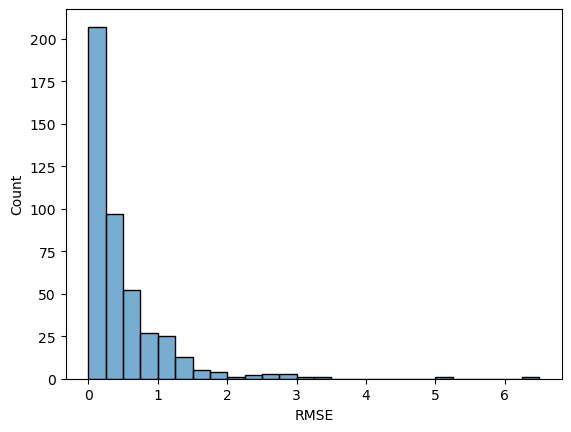

In [111]:
gp = sns.histplot(final3, x="RMSE", alpha=0.6, binwidth=0.25)

In [112]:
df_plot = final3.explode(["T", "Test Actual","Test Predict"]).reset_index(drop=True)
df_plot

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE,RMSE2
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.150,CHO,338.0,7.357635,6.428063,0.498634,Pass
1,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.150,CHO,367.75,8.529598,8.058521,0.498634,Pass
2,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.150,CHO,397.5,9.45614,9.409872,0.498634,Pass
3,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.150,CHO,427.25,10.81968,10.548132,0.498634,Pass
4,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.150,CHO,457.0,11.805124,11.520021,0.498634,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,CC(C(=O)OC(C)C(=O)OC)O,4.362529,-25.478414,-362.688620,22.802385,4587.163971,-90.15,22.986339,5332.388728,-39.595,CHO,317.0,3.367925,2.581252,0.427255,Pass
2211,CC(C(=O)OC(C)C(=O)OC)O,4.362529,-25.478414,-362.688620,22.802385,4587.163971,-90.15,22.986339,5332.388728,-39.595,CHO,333.75,3.528499,3.971663,0.427255,Pass
2212,CC(C(=O)OC(C)C(=O)OC)O,4.362529,-25.478414,-362.688620,22.802385,4587.163971,-90.15,22.986339,5332.388728,-39.595,CHO,350.5,5.45099,5.183165,0.427255,Pass
2213,CC(C(=O)OC(C)C(=O)OC)O,4.362529,-25.478414,-362.688620,22.802385,4587.163971,-90.15,22.986339,5332.388728,-39.595,CHO,367.25,6.17155,6.248203,0.427255,Pass


(-20.0, 25.0)

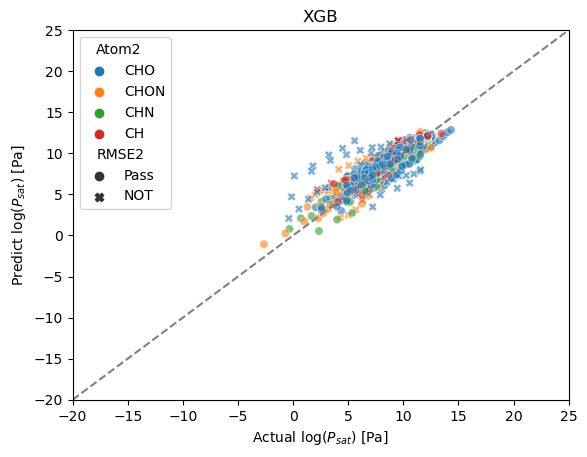

In [113]:
# Specified Range for plot
x_min = -20;  x_max = 25
y_min, y_max = x_min, x_max

# Plot each method
#Test Predict	Test Actual

#plt.plot(x = final3["Test Predict"], y = final3["Test Predict"])
markers = {"Pass": "o", "NOT": "X"}
gc = sns.scatterplot(df_plot, x="Test Actual", y="Test Predict", hue="Atom2", style= "RMSE2", alpha=0.6, markers=markers)
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

# Add Legend, range of show
plt.title(best_name)
plt.xlabel("Actual log($P_{sat}$) [Pa]")
plt.ylabel("Predict log($P_{sat}$) [Pa]")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
#gc.xlabels("Actual log($P_{sat}$) [Pa]")
#plt.ylabel("Predict log($P_{sat}$) [Pa]")
#gc.set_xlabels("Actual log($P_{sat}$) [Pa]")
#gc.set_ylabels("Predict log($P_{sat}$) [Pa]")

(-31.251479874826245, 61.250905164608525)

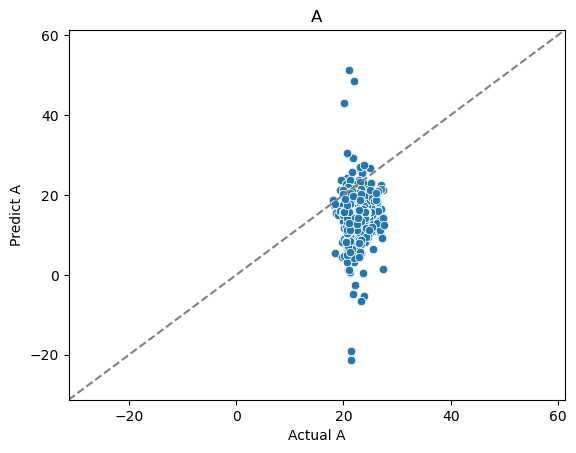

In [114]:
x_min = min(min(df_plot["A"]), min(df_plot["A_Pred"]))-10
x_max = max(max(df_plot["A"]), max(df_plot["A_Pred"]))+10
y_min = x_min; y_max = x_max

sns.scatterplot(df_plot, x="A", y="A_Pred")
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

text = "A"
plt.title(text)
plt.xlabel(f"Actual {text}")
plt.ylabel(f"Predict {text}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-10000.0, 40000.0)

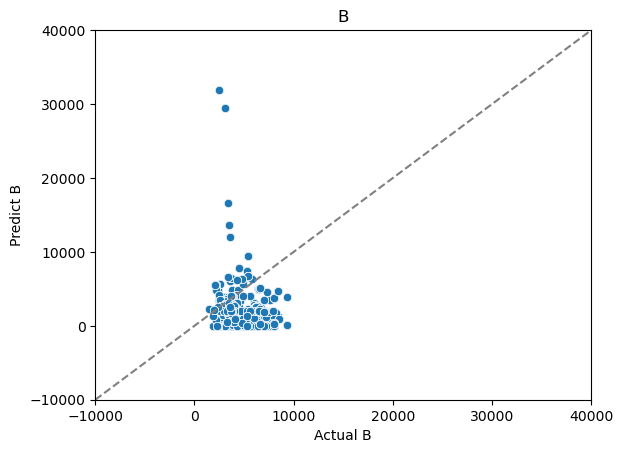

In [115]:
#x_min = min(min(df_plot["B"]), min(df_plot["B_Pred"]))
#x_max = max(max(df_plot["B"]), max(df_plot["B_Pred"]))+1000
x_min = -10000; x_max = 40000
y_min = x_min; y_max = x_max

sns.scatterplot(df_plot, x="B", y="B_Pred")
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

text = "B"
plt.title(text)
plt.xlabel(f"Actual {text}")
plt.ylabel(f"Predict {text}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

(-1175.9518369852692, 851.9287729726395)

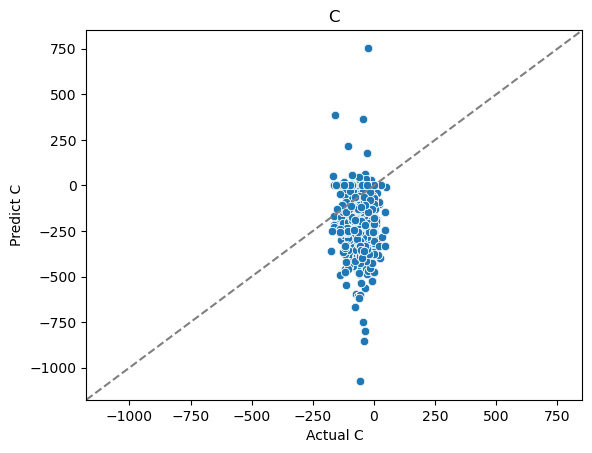

In [116]:
x_min = min(min(df_plot["C"]), min(df_plot["C_Pred"]))-100
x_max = max(max(df_plot["C"]), max(df_plot["C_Pred"]))+100
#x_min = -10000; x_max = 40000
y_min = x_min; y_max = x_max

sns.scatterplot(df_plot, x="C", y="C_Pred")
plt.axline((0, 0), slope=1, color='.5', linestyle='--')

text = "C"
plt.title(text)
plt.xlabel(f"Actual {text}")
plt.ylabel(f"Predict {text}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [117]:
df_plot["Diff"] = abs(df_plot["Test Actual"] - df_plot["Test Predict"])
df_plot.head(2)

,SMILES,A_Pred,B_Pred,C_Pred,A_test,B_test,C_test,A,B,C,Atom2,T,Test Predict,Test Actual,RMSE,RMSE2,Diff
0,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.15,CHO,338.0,7.357635,6.428063,0.498634,Pass,0.929572
1,CCOC(=O)N,6.066632,243.839281,-485.357736,23.846838,5018.000667,-49.92,21.370292,2204.126554,-30.15,CHO,367.75,8.529598,8.058521,0.498634,Pass,0.471077


Text(0, 0.5, 'Error log($P_{sat}$) [Pa]')

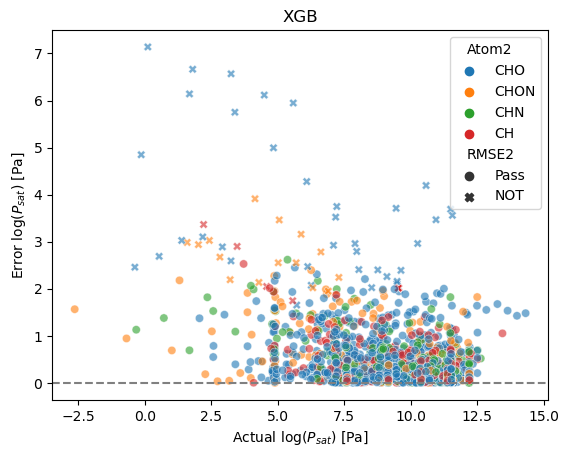

In [118]:
# Plot each method
sns.scatterplot(df_plot, x="Test Actual", y="Diff", alpha=0.6, hue="Atom2", style="RMSE2")
plt.axline((0, 0), slope=0, color='.5', linestyle='--')
plt.title(best_name)
plt.xlabel("Actual log($P_{sat}$) [Pa]")
plt.ylabel("Error log($P_{sat}$) [Pa]")

#plt.xlim(x_min, x_max)

In [119]:
import imageio                                          # create an animation (.gif)
# create the animation (.gif)!!!
with imageio.get_writer('myAnimation2.gif', fps=60) as writer:    # inputs: filename, frame per second
    for filename in filenames:
        image = imageio.v2.imread(filename)                         # load the image file
        #print(image)
        #writer.append_data(image)                                # append the image file
print('Gif saved!\n')

Gif saved!



In [344]:
filenames

[]

In [137]:
dff = df2_train.sort_values(by="Vapor_Presssure",ascending=False).head(10)
dff

,index,SMILES,T,Vapor_Presssure
4034,4034,C1CCC(C1)N,418.0,19.099075
4033,4033,C1CCC(C1)N,393.0,18.971667
4032,4032,C1CCC(C1)N,368.0,18.822911
4031,4031,C1CCC(C1)N,343.0,18.646947
4030,4030,C1CCC(C1)N,318.0,18.435562
54,54,CCO,514.0,15.622714
2389,2389,C(#N)C#N,399.0,15.566501
2059,2059,C1COCCO1,583.0,15.407496
1194,1194,CC(=O)OC=C,519.0,15.198214
1419,1419,CCOC=C,472.0,15.161336


In [138]:
dff.merge(df_join, on="SMILES", how='inner')
#.merge(df_SMILES_CHON, on='SMILES', how='inner')

,index,SMILES,T,Vapor_Presssure,Name,Atom2
0,4034,C1CCC(C1)N,418.0,19.099075,Cyclopentyl amine,CHN
1,4033,C1CCC(C1)N,393.0,18.971667,Cyclopentyl amine,CHN
2,4032,C1CCC(C1)N,368.0,18.822911,Cyclopentyl amine,CHN
3,4031,C1CCC(C1)N,343.0,18.646947,Cyclopentyl amine,CHN
4,4030,C1CCC(C1)N,318.0,18.435562,Cyclopentyl amine,CHN
5,54,CCO,514.0,15.622714,Ethanol,CHO
6,2389,C(#N)C#N,399.0,15.566501,Cyanogene,CN
7,2059,C1COCCO1,583.0,15.407496,"1,4-Dioxane",CHO
8,1194,CC(=O)OC=C,519.0,15.198214,Ethenyl ethanoate,CHO
9,1419,CCOC=C,472.0,15.161336,Ethyl vinyl ether,CHO


In [139]:
dfff= dff.merge(df_join, on="SMILES", how='inner')
dfff

,index,SMILES,T,Vapor_Presssure,Name,Atom2
0,4034,C1CCC(C1)N,418.0,19.099075,Cyclopentyl amine,CHN
1,4033,C1CCC(C1)N,393.0,18.971667,Cyclopentyl amine,CHN
2,4032,C1CCC(C1)N,368.0,18.822911,Cyclopentyl amine,CHN
3,4031,C1CCC(C1)N,343.0,18.646947,Cyclopentyl amine,CHN
4,4030,C1CCC(C1)N,318.0,18.435562,Cyclopentyl amine,CHN
5,54,CCO,514.0,15.622714,Ethanol,CHO
6,2389,C(#N)C#N,399.0,15.566501,Cyanogene,CN
7,2059,C1COCCO1,583.0,15.407496,"1,4-Dioxane",CHO
8,1194,CC(=O)OC=C,519.0,15.198214,Ethenyl ethanoate,CHO
9,1419,CCOC=C,472.0,15.161336,Ethyl vinyl ether,CHO


In [140]:
dfff[dfff["Name"]=="Ethanol"]

,index,SMILES,T,Vapor_Presssure,Name,Atom2
5,54,CCO,514.0,15.622714,Ethanol,CHO


In [ ]:
df